# Import libraries and data

In [12]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
xtrain = pd.read_csv('Xtrain.csv')
ytrain = pd.read_csv('Ytrain.csv')
xtrain.dtypes

Id                     int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
dtype: object

In [14]:
for column in xtrain.columns:
    print(column,len(xtrain[column].unique()))

Id 50000
Name 48757
City 9488
State 51
Zip 13794
Bank 2784
BankState 53
NAICS 1118
ApprovalDate 6934
ApprovalFY 47
Term 325
NoEmp 207
NewExist 4
CreateJob 98
RetainedJob 144
FranchiseCode 849
UrbanRural 3
RevLineCr 5
LowDoc 8
DisbursementDate 2434
DisbursementGross 14120
BalanceGross 1
GrAppv 3951
SBA_Appv 6048


In [15]:
xtrain.head()

,Id,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv
0,0,"NPE Realty, LLC",Pembroke Pines,FL,33027,"TD BANK, NATIONAL ASSOCIATION",DE,334516,16-Apr-10,2010,...,0,0,1,N,N,1-May-10,"$2,000,000.00",$0.00,"$2,000,000.00","$1,500,000.00"
1,1,"KEVCO CONSTRUCTION, LLC",SANDY,UT,84094,ZIONS FIRST NATIONAL BANK,UT,236115,30-Jan-10,2010,...,3,0,1,N,N,1-Feb-10,"$17,000.00",$0.00,"$17,000.00","$17,000.00"
2,2,EAST L A SHOE REPAIR,LOS ANGELES,CA,90022,BANK OF AMERICA NATL ASSOC,NC,811430,29-Jul-02,2002,...,1,1,1,Y,N,31-Aug-02,"$17,000.00",$0.00,"$17,000.00","$8,500.00"
3,3,"RUSSLER, DANIEL C, MD",LODI,WI,53555,ASSOCIATED BANK NATL ASSOC,WI,0,10-Jun-94,1994,...,0,1,0,N,N,31-Jul-94,"$137,000.00",$0.00,"$137,000.00","$123,300.00"
4,4,AFFORDABLE FAMILY DENISTRY LLC,LEBANON,MO,65536,COMMERCE BANK,MO,621210,6-Feb-06,2006,...,2,1,1,T,N,31-Mar-06,"$46,665.00",$0.00,"$25,000.00","$12,500.00"


# Data Preprocessing

In [16]:
# remove missing values

xtrain.fillna(-999, inplace=True)

In [17]:
# transform "GrAppv", "SBA_Appv", DisbursementGross" into ratios
# transform "DisbursementDate" to "DisbursementYear"

def bank_rate(row):
    bank = float(''.join(row['GrAppv'][1:-4].split(',')))
    gross = float(''.join(row['DisbursementGross'][1:-4].split(',')))
    if gross!=0:
        return bank/gross
    return 0

def sba_rate(row):
    sba = float(''.join(row['SBA_Appv'][1:-4].split(',')))
    gross = float(''.join(row['DisbursementGross'][1:-4].split(',')))
    if gross!=0:
        return sba/gross
    return 0

def date_to_year(row):
    if isinstance(row['DisbursementDate'], str):
        return row['DisbursementDate'].split('-')[-1]
    return 0

In [18]:
xtrain['BankRate'] = xtrain.apply (lambda row: bank_rate(row), axis=1)
xtrain['SBARate'] = xtrain.apply (lambda row: sba_rate(row), axis=1)
xtrain['DisbursementFY'] = xtrain.apply(lambda row: date_to_year(row), axis=1)

# drop unneccessary columns

xtrain = xtrain.drop(columns=['Id','Name','Zip','State','BankState','ApprovalDate','DisbursementDate','DisbursementGross','BalanceGross','GrAppv','SBA_Appv'])

In [19]:
# transform to CatBoost-supported format

xtrain_cat = xtrain.copy()
xtrain_cat.dtypes

City               object
Bank               object
NAICS               int64
ApprovalFY         object
Term                int64
NoEmp               int64
NewExist          float64
CreateJob           int64
RetainedJob         int64
FranchiseCode       int64
UrbanRural          int64
RevLineCr          object
LowDoc             object
BankRate          float64
SBARate           float64
DisbursementFY     object
dtype: object

In [20]:
xtrain_cat['NewExist'] = xtrain_cat['NewExist'].astype(np.int)

# indicate which features are treated as categorical features

categorical_features_indices = [0,1,2,3,6,9,10,11,12,15]

In [25]:
# transform to GBM and XGBoost supported format (numericalize)

object_columns = xtrain.select_dtypes(np.object).columns
xtrain[object_columns] = xtrain[object_columns].astype('category')
xtrain[object_columns] = xtrain[object_columns].apply(lambda x: x.cat.codes)

In [26]:
xtrain.head()

,City,Bank,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,BankRate,SBARate,DisbursementFY
0,6765,2373,334516,42,130,25,1.0,2,0,0,1,2,4,1.000000,0.750000,11
1,7382,2783,236115,42,33,6,1.0,1,3,0,1,2,4,1.000000,1.000000,11
2,4670,211,811430,34,60,1,1.0,1,1,1,1,4,4,1.000000,0.500000,3
3,4628,169,0,26,160,1,2.0,0,0,1,0,2,4,1.000000,0.900000,40
4,4487,654,621210,38,101,2,1.0,7,2,1,1,3,4,0.535733,0.267867,7


In [27]:
xtrain_numerical = xtrain.copy()

In [28]:
# one-hot encoding some of the features

inf = float('inf')
xtrain.Term = pd.qcut(x=xtrain.Term, q=10, labels=False, duplicates='drop')
xtrain.NoEmp = pd.qcut(x=xtrain.NoEmp, q=10, labels=False, duplicates='drop')
xtrain.CreateJob = pd.qcut(x=xtrain.CreateJob, q=10, labels=False, duplicates='drop')
xtrain.RetainedJob = pd.qcut(x=xtrain.RetainedJob, q=10, labels=False, duplicates='drop')
xtrain.BankRate = pd.qcut(x=xtrain.BankRate, q=10, labels=False, duplicates='drop')
xtrain.SBARate = pd.qcut(x=xtrain.SBARate, q=10, labels=False, duplicates='drop')

In [29]:
xtrain = xtrain.join(pd.get_dummies(xtrain.Term, prefix='term'))
xtrain = xtrain.join(pd.get_dummies(xtrain.NoEmp, prefix='noemp'))
xtrain = xtrain.join(pd.get_dummies(xtrain.NewExist, prefix='newexist'))
xtrain = xtrain.join(pd.get_dummies(xtrain.CreateJob, prefix='createjob'))
xtrain = xtrain.join(pd.get_dummies(xtrain.RetainedJob, prefix='retainedjob'))
xtrain = xtrain.join(pd.get_dummies(xtrain.UrbanRural, prefix='urbanrural'))
xtrain = xtrain.join(pd.get_dummies(xtrain.RevLineCr, prefix='revlinecr'))
xtrain = xtrain.join(pd.get_dummies(xtrain.LowDoc, prefix='lowdoc'))
xtrain = xtrain.join(pd.get_dummies(xtrain.BankRate, prefix='bankrate'))
xtrain = xtrain.join(pd.get_dummies(xtrain.SBARate, prefix='sbarate'))
xtrain = xtrain.drop(columns=['Term','NoEmp','NewExist','CreateJob','RetainedJob','UrbanRural','RevLineCr','LowDoc','BankRate','SBARate'])

In [30]:
xtrain.head()

,City,Bank,NAICS,ApprovalFY,FranchiseCode,DisbursementFY,term_0,term_1,term_2,term_3,...,bankrate_2,bankrate_3,sbarate_0,sbarate_1,sbarate_2,sbarate_3,sbarate_4,sbarate_5,sbarate_6,sbarate_7
0,6765,2373,334516,42,0,11,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,7382,2783,236115,42,0,11,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,4670,211,811430,34,1,3,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
3,4628,169,0,26,1,40,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,4487,654,621210,38,1,7,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# Training

In [31]:
# (x1, y1): GBM & XGBoost with numerical features
# (x2, y2): GBM & XGBoost with one-hot encodings
# (x3, y3): CatBoost

x1 = xtrain
y1 = ytrain['ChargeOff']
x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.25, random_state=0)

x2 = xtrain_numerical
y2 = ytrain['ChargeOff']

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size = 0.25, random_state=0)

x3 = xtrain_cat
y3 = ytrain['ChargeOff']
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size = 0.25, random_state=0)

## GBM & XGBoost

In [32]:
model_names = ['GBM', 'XGB']
pima1_acc = []
pima2_acc = []
pima1_f1 = []
pima2_f1 = []

for model in [GradientBoostingClassifier(), xgb.XGBClassifier()]:
    model.fit(x_train1, y_train1)
    y_pred1 = model.predict(x_test1)
    acc = round(accuracy_score(y_test1, y_pred1) * 100, 2)
    f1 = round(f1_score(y_test1, y_pred1, average='weighted') * 100, 2)
    pima1_acc.append(acc)
    pima1_f1.append(f1)

for model in [GradientBoostingClassifier(), xgb.XGBClassifier()]:
    model.fit(x_train2, y_train2)
    y_pred2 = model.predict(x_test2)
    acc = round(accuracy_score(y_test2, y_pred2) * 100, 2)
    f1 = round(f1_score(y_test2, y_pred2, average='weighted') * 100, 2)
    pima2_acc.append(acc)
    pima2_f1.append(f1)


accuracy_record = pd.DataFrame({'Model': model_names, 'pima1_acc': pima1_acc, 'pima2_acc': pima2_acc})
accuracy_record['acc_mean'] = accuracy_record.mean(axis=1).round(2)
accuracy_record.set_index('Model', inplace=True)
accuracy_record.loc['avg'] = accuracy_record.mean()

F1_record = pd.DataFrame({'Model': model_names, 'pima1_f1': pima1_f1, 'pima2_f1': pima2_f1})
F1_record['F1_mean'] = F1_record.mean(axis=1).round(2)
F1_record.set_index('Model', inplace=True)
F1_record.loc['avg'] = F1_record.mean()

print(accuracy_record)
print('\n')
print(F1_record)

       pima1_acc  pima2_acc  acc_mean
Model                                
GBM       83.780     89.640    86.710
XGB       85.250     92.550    88.900
avg       84.515     91.095    87.805


       pima1_f1  pima2_f1  F1_mean
Model                             
GBM      83.760    89.640   86.700
XGB      85.230    92.550   88.890
avg      84.495    91.095   87.795


## CatBoost

In [33]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
}
train_pool = Pool(x_train3, y_train3, cat_features=categorical_features_indices)
validate_pool = Pool(x_test3, y_test3, cat_features=categorical_features_indices)

In [34]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

print('Best model validation accuracy: {:.4}'.format(
    accuracy_score(y_test3, model.predict(x_test3))
))

Best model validation accuracy: 0.9305


# Hyperparameters Tuning

## XGBoost

In [324]:
param_test1 = {
 'min_child_weight':[i/5.0 for i in range(1,6)]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x2,y2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
          

In [325]:
print(gsearch1.best_params_, gsearch1.best_score_)

{'min_child_weight': 0.8} 0.973344133777079


In [326]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=0.8, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(x2,y2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=0.8,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambd

In [327]:
print(gsearch3.best_params_, gsearch3.best_score_)

{'gamma': 0.0} 0.973344133777079


In [332]:
param_test4 = {
#  'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/50.0 for i in range(45,51)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=0.8, gamma=0.0, subsample=0.7, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(x1,y1)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=0.8,
                                     missing=nan, monotone_constraints=Non...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, su

In [333]:
print(gsearch4.best_params_, gsearch4.best_score_)

{'colsample_bytree': 0.9} 0.924085128824489


In [353]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-4, 1e-3]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=0.8, gamma=0.1, subsample=0.7, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(x2,y2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=0.8,
                                     missing=nan, monotone_constraints=Non...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, su

In [354]:
print(gsearch6.best_params_, gsearch6.best_score_)

{'reg_alpha': 1e-05} 0.9745253239669843


## CatBoost

In [112]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        iterations=500,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(x3, y3, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [113]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████| 30/30 [1:20:49<00:00, 161.66s/trial, best loss: 0.07847999766273717]
{'l2_leaf_reg': 1.0}


# Early Stopping

## XGBoost

In [370]:
model = xgb.XGBClassifier(learning_rate=0.01, n_estimators=10000, max_depth=4,
 min_child_weight=0.8, gamma=0.0, subsample=0.7, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, reg_alpha=1e-5)
model.fit(x_train2, y_train2, eval_metric=['logloss','error'], eval_set=[(x_train2, y_train2), (x_test2, y_test2)], si)

[0]	validation_0-logloss:0.68721	validation_0-error:0.13256	validation_1-logloss:0.68727	validation_1-error:0.13488
[1]	validation_0-logloss:0.68502	validation_0-error:0.13389	validation_1-logloss:0.68505	validation_1-error:0.13672
[2]	validation_0-logloss:0.67925	validation_0-error:0.12531	validation_1-logloss:0.67936	validation_1-error:0.12784
[3]	validation_0-logloss:0.67382	validation_0-error:0.12453	validation_1-logloss:0.67396	validation_1-error:0.12680
[4]	validation_0-logloss:0.67169	validation_0-error:0.12704	validation_1-logloss:0.67184	validation_1-error:0.12944
[5]	validation_0-logloss:0.66624	validation_0-error:0.12685	validation_1-logloss:0.66641	validation_1-error:0.12896
[6]	validation_0-logloss:0.66087	validation_0-error:0.12552	validation_1-logloss:0.66109	validation_1-error:0.12848
[7]	validation_0-logloss:0.65558	validation_0-error:0.12571	validation_1-logloss:0.65581	validation_1-error:0.12776
[8]	validation_0-logloss:0.65043	validation_0-error:0.12573	validation_1

[71]	validation_0-logloss:0.46387	validation_0-error:0.12667	validation_1-logloss:0.46653	validation_1-error:0.12936
[72]	validation_0-logloss:0.46200	validation_0-error:0.12669	validation_1-logloss:0.46470	validation_1-error:0.12936
[73]	validation_0-logloss:0.46012	validation_0-error:0.12675	validation_1-logloss:0.46286	validation_1-error:0.12928
[74]	validation_0-logloss:0.45834	validation_0-error:0.12693	validation_1-logloss:0.46113	validation_1-error:0.13000
[75]	validation_0-logloss:0.45639	validation_0-error:0.12693	validation_1-logloss:0.45921	validation_1-error:0.13016
[76]	validation_0-logloss:0.45462	validation_0-error:0.12699	validation_1-logloss:0.45748	validation_1-error:0.13024
[77]	validation_0-logloss:0.45272	validation_0-error:0.12696	validation_1-logloss:0.45559	validation_1-error:0.13024
[78]	validation_0-logloss:0.45084	validation_0-error:0.12704	validation_1-logloss:0.45373	validation_1-error:0.13024
[79]	validation_0-logloss:0.44916	validation_0-error:0.12699	val

[141]	validation_0-logloss:0.37693	validation_0-error:0.12245	validation_1-logloss:0.38118	validation_1-error:0.12560
[142]	validation_0-logloss:0.37650	validation_0-error:0.12235	validation_1-logloss:0.38075	validation_1-error:0.12552
[143]	validation_0-logloss:0.37564	validation_0-error:0.12240	validation_1-logloss:0.37989	validation_1-error:0.12520
[144]	validation_0-logloss:0.37485	validation_0-error:0.12232	validation_1-logloss:0.37912	validation_1-error:0.12528
[145]	validation_0-logloss:0.37400	validation_0-error:0.12235	validation_1-logloss:0.37826	validation_1-error:0.12520
[146]	validation_0-logloss:0.37305	validation_0-error:0.12269	validation_1-logloss:0.37732	validation_1-error:0.12544
[147]	validation_0-logloss:0.37226	validation_0-error:0.12248	validation_1-logloss:0.37653	validation_1-error:0.12536
[148]	validation_0-logloss:0.37147	validation_0-error:0.12240	validation_1-logloss:0.37579	validation_1-error:0.12520
[149]	validation_0-logloss:0.37056	validation_0-error:0.

[211]	validation_0-logloss:0.33303	validation_0-error:0.11563	validation_1-logloss:0.33775	validation_1-error:0.11960
[212]	validation_0-logloss:0.33252	validation_0-error:0.11547	validation_1-logloss:0.33723	validation_1-error:0.11944
[213]	validation_0-logloss:0.33203	validation_0-error:0.11552	validation_1-logloss:0.33672	validation_1-error:0.11920
[214]	validation_0-logloss:0.33152	validation_0-error:0.11547	validation_1-logloss:0.33620	validation_1-error:0.11904
[215]	validation_0-logloss:0.33103	validation_0-error:0.11541	validation_1-logloss:0.33570	validation_1-error:0.11904
[216]	validation_0-logloss:0.33051	validation_0-error:0.11533	validation_1-logloss:0.33517	validation_1-error:0.11872
[217]	validation_0-logloss:0.32991	validation_0-error:0.11520	validation_1-logloss:0.33456	validation_1-error:0.11840
[218]	validation_0-logloss:0.32944	validation_0-error:0.11509	validation_1-logloss:0.33413	validation_1-error:0.11840
[219]	validation_0-logloss:0.32891	validation_0-error:0.

[281]	validation_0-logloss:0.30455	validation_0-error:0.11000	validation_1-logloss:0.30887	validation_1-error:0.11136
[282]	validation_0-logloss:0.30421	validation_0-error:0.11019	validation_1-logloss:0.30854	validation_1-error:0.11136
[283]	validation_0-logloss:0.30386	validation_0-error:0.11000	validation_1-logloss:0.30817	validation_1-error:0.11128
[284]	validation_0-logloss:0.30351	validation_0-error:0.10995	validation_1-logloss:0.30782	validation_1-error:0.11136
[285]	validation_0-logloss:0.30329	validation_0-error:0.10995	validation_1-logloss:0.30760	validation_1-error:0.11104
[286]	validation_0-logloss:0.30288	validation_0-error:0.10987	validation_1-logloss:0.30716	validation_1-error:0.11104
[287]	validation_0-logloss:0.30262	validation_0-error:0.10981	validation_1-logloss:0.30690	validation_1-error:0.11120
[288]	validation_0-logloss:0.30229	validation_0-error:0.10968	validation_1-logloss:0.30657	validation_1-error:0.11104
[289]	validation_0-logloss:0.30202	validation_0-error:0.

[351]	validation_0-logloss:0.28642	validation_0-error:0.10637	validation_1-logloss:0.29077	validation_1-error:0.10888
[352]	validation_0-logloss:0.28625	validation_0-error:0.10643	validation_1-logloss:0.29061	validation_1-error:0.10872
[353]	validation_0-logloss:0.28602	validation_0-error:0.10632	validation_1-logloss:0.29038	validation_1-error:0.10888
[354]	validation_0-logloss:0.28586	validation_0-error:0.10632	validation_1-logloss:0.29022	validation_1-error:0.10888
[355]	validation_0-logloss:0.28557	validation_0-error:0.10611	validation_1-logloss:0.28994	validation_1-error:0.10872
[356]	validation_0-logloss:0.28541	validation_0-error:0.10608	validation_1-logloss:0.28978	validation_1-error:0.10880
[357]	validation_0-logloss:0.28526	validation_0-error:0.10608	validation_1-logloss:0.28963	validation_1-error:0.10864
[358]	validation_0-logloss:0.28510	validation_0-error:0.10605	validation_1-logloss:0.28948	validation_1-error:0.10872
[359]	validation_0-logloss:0.28486	validation_0-error:0.

[421]	validation_0-logloss:0.27320	validation_0-error:0.10219	validation_1-logloss:0.27778	validation_1-error:0.10608
[422]	validation_0-logloss:0.27300	validation_0-error:0.10216	validation_1-logloss:0.27757	validation_1-error:0.10600
[423]	validation_0-logloss:0.27287	validation_0-error:0.10224	validation_1-logloss:0.27744	validation_1-error:0.10600
[424]	validation_0-logloss:0.27275	validation_0-error:0.10232	validation_1-logloss:0.27732	validation_1-error:0.10600
[425]	validation_0-logloss:0.27252	validation_0-error:0.10229	validation_1-logloss:0.27709	validation_1-error:0.10600
[426]	validation_0-logloss:0.27241	validation_0-error:0.10227	validation_1-logloss:0.27699	validation_1-error:0.10592
[427]	validation_0-logloss:0.27230	validation_0-error:0.10200	validation_1-logloss:0.27689	validation_1-error:0.10568
[428]	validation_0-logloss:0.27210	validation_0-error:0.10205	validation_1-logloss:0.27669	validation_1-error:0.10568
[429]	validation_0-logloss:0.27198	validation_0-error:0.

[491]	validation_0-logloss:0.26304	validation_0-error:0.09851	validation_1-logloss:0.26774	validation_1-error:0.10264
[492]	validation_0-logloss:0.26284	validation_0-error:0.09853	validation_1-logloss:0.26755	validation_1-error:0.10288
[493]	validation_0-logloss:0.26264	validation_0-error:0.09864	validation_1-logloss:0.26737	validation_1-error:0.10312
[494]	validation_0-logloss:0.26248	validation_0-error:0.09840	validation_1-logloss:0.26720	validation_1-error:0.10304
[495]	validation_0-logloss:0.26231	validation_0-error:0.09832	validation_1-logloss:0.26703	validation_1-error:0.10296
[496]	validation_0-logloss:0.26216	validation_0-error:0.09819	validation_1-logloss:0.26689	validation_1-error:0.10256
[497]	validation_0-logloss:0.26194	validation_0-error:0.09813	validation_1-logloss:0.26667	validation_1-error:0.10272
[498]	validation_0-logloss:0.26187	validation_0-error:0.09813	validation_1-logloss:0.26660	validation_1-error:0.10256
[499]	validation_0-logloss:0.26179	validation_0-error:0.

[561]	validation_0-logloss:0.25425	validation_0-error:0.09560	validation_1-logloss:0.25943	validation_1-error:0.10112
[562]	validation_0-logloss:0.25418	validation_0-error:0.09555	validation_1-logloss:0.25937	validation_1-error:0.10112
[563]	validation_0-logloss:0.25412	validation_0-error:0.09549	validation_1-logloss:0.25931	validation_1-error:0.10104
[564]	validation_0-logloss:0.25403	validation_0-error:0.09541	validation_1-logloss:0.25921	validation_1-error:0.10088
[565]	validation_0-logloss:0.25398	validation_0-error:0.09536	validation_1-logloss:0.25916	validation_1-error:0.10088
[566]	validation_0-logloss:0.25383	validation_0-error:0.09531	validation_1-logloss:0.25902	validation_1-error:0.10088
[567]	validation_0-logloss:0.25365	validation_0-error:0.09528	validation_1-logloss:0.25880	validation_1-error:0.10072
[568]	validation_0-logloss:0.25357	validation_0-error:0.09531	validation_1-logloss:0.25872	validation_1-error:0.10072
[569]	validation_0-logloss:0.25341	validation_0-error:0.

[631]	validation_0-logloss:0.24688	validation_0-error:0.09320	validation_1-logloss:0.25239	validation_1-error:0.09944
[632]	validation_0-logloss:0.24681	validation_0-error:0.09309	validation_1-logloss:0.25233	validation_1-error:0.09936
[633]	validation_0-logloss:0.24655	validation_0-error:0.09304	validation_1-logloss:0.25214	validation_1-error:0.09936
[634]	validation_0-logloss:0.24648	validation_0-error:0.09299	validation_1-logloss:0.25206	validation_1-error:0.09936
[635]	validation_0-logloss:0.24640	validation_0-error:0.09307	validation_1-logloss:0.25201	validation_1-error:0.09936
[636]	validation_0-logloss:0.24635	validation_0-error:0.09291	validation_1-logloss:0.25196	validation_1-error:0.09944
[637]	validation_0-logloss:0.24631	validation_0-error:0.09291	validation_1-logloss:0.25194	validation_1-error:0.09936
[638]	validation_0-logloss:0.24613	validation_0-error:0.09293	validation_1-logloss:0.25177	validation_1-error:0.09944
[639]	validation_0-logloss:0.24602	validation_0-error:0.

[701]	validation_0-logloss:0.24003	validation_0-error:0.09059	validation_1-logloss:0.24629	validation_1-error:0.09640
[702]	validation_0-logloss:0.23996	validation_0-error:0.09067	validation_1-logloss:0.24626	validation_1-error:0.09648
[703]	validation_0-logloss:0.23988	validation_0-error:0.09064	validation_1-logloss:0.24618	validation_1-error:0.09656
[704]	validation_0-logloss:0.23973	validation_0-error:0.09056	validation_1-logloss:0.24601	validation_1-error:0.09656
[705]	validation_0-logloss:0.23965	validation_0-error:0.09059	validation_1-logloss:0.24594	validation_1-error:0.09640
[706]	validation_0-logloss:0.23960	validation_0-error:0.09056	validation_1-logloss:0.24590	validation_1-error:0.09632
[707]	validation_0-logloss:0.23955	validation_0-error:0.09051	validation_1-logloss:0.24586	validation_1-error:0.09640
[708]	validation_0-logloss:0.23941	validation_0-error:0.09051	validation_1-logloss:0.24573	validation_1-error:0.09616
[709]	validation_0-logloss:0.23933	validation_0-error:0.

[771]	validation_0-logloss:0.23427	validation_0-error:0.08845	validation_1-logloss:0.24110	validation_1-error:0.09376
[772]	validation_0-logloss:0.23414	validation_0-error:0.08835	validation_1-logloss:0.24097	validation_1-error:0.09384
[773]	validation_0-logloss:0.23407	validation_0-error:0.08827	validation_1-logloss:0.24090	validation_1-error:0.09352
[774]	validation_0-logloss:0.23398	validation_0-error:0.08824	validation_1-logloss:0.24081	validation_1-error:0.09352
[775]	validation_0-logloss:0.23389	validation_0-error:0.08824	validation_1-logloss:0.24073	validation_1-error:0.09344
[776]	validation_0-logloss:0.23386	validation_0-error:0.08824	validation_1-logloss:0.24071	validation_1-error:0.09336
[777]	validation_0-logloss:0.23373	validation_0-error:0.08813	validation_1-logloss:0.24058	validation_1-error:0.09320
[778]	validation_0-logloss:0.23365	validation_0-error:0.08811	validation_1-logloss:0.24051	validation_1-error:0.09328
[779]	validation_0-logloss:0.23361	validation_0-error:0.

[841]	validation_0-logloss:0.22927	validation_0-error:0.08589	validation_1-logloss:0.23674	validation_1-error:0.09184
[842]	validation_0-logloss:0.22923	validation_0-error:0.08600	validation_1-logloss:0.23671	validation_1-error:0.09200
[843]	validation_0-logloss:0.22920	validation_0-error:0.08603	validation_1-logloss:0.23668	validation_1-error:0.09192
[844]	validation_0-logloss:0.22917	validation_0-error:0.08600	validation_1-logloss:0.23667	validation_1-error:0.09176
[845]	validation_0-logloss:0.22913	validation_0-error:0.08600	validation_1-logloss:0.23664	validation_1-error:0.09176
[846]	validation_0-logloss:0.22906	validation_0-error:0.08595	validation_1-logloss:0.23656	validation_1-error:0.09168
[847]	validation_0-logloss:0.22897	validation_0-error:0.08587	validation_1-logloss:0.23647	validation_1-error:0.09168
[848]	validation_0-logloss:0.22893	validation_0-error:0.08579	validation_1-logloss:0.23645	validation_1-error:0.09160
[849]	validation_0-logloss:0.22891	validation_0-error:0.

[911]	validation_0-logloss:0.22454	validation_0-error:0.08453	validation_1-logloss:0.23260	validation_1-error:0.09008
[912]	validation_0-logloss:0.22447	validation_0-error:0.08453	validation_1-logloss:0.23254	validation_1-error:0.09008
[913]	validation_0-logloss:0.22437	validation_0-error:0.08456	validation_1-logloss:0.23245	validation_1-error:0.09008
[914]	validation_0-logloss:0.22431	validation_0-error:0.08459	validation_1-logloss:0.23238	validation_1-error:0.09008
[915]	validation_0-logloss:0.22417	validation_0-error:0.08451	validation_1-logloss:0.23226	validation_1-error:0.08992
[916]	validation_0-logloss:0.22412	validation_0-error:0.08445	validation_1-logloss:0.23221	validation_1-error:0.08984
[917]	validation_0-logloss:0.22409	validation_0-error:0.08440	validation_1-logloss:0.23219	validation_1-error:0.08968
[918]	validation_0-logloss:0.22403	validation_0-error:0.08443	validation_1-logloss:0.23212	validation_1-error:0.08968
[919]	validation_0-logloss:0.22398	validation_0-error:0.

[981]	validation_0-logloss:0.22044	validation_0-error:0.08288	validation_1-logloss:0.22904	validation_1-error:0.08912
[982]	validation_0-logloss:0.22032	validation_0-error:0.08285	validation_1-logloss:0.22892	validation_1-error:0.08896
[983]	validation_0-logloss:0.22030	validation_0-error:0.08288	validation_1-logloss:0.22892	validation_1-error:0.08896
[984]	validation_0-logloss:0.22027	validation_0-error:0.08293	validation_1-logloss:0.22888	validation_1-error:0.08904
[985]	validation_0-logloss:0.22020	validation_0-error:0.08293	validation_1-logloss:0.22881	validation_1-error:0.08912
[986]	validation_0-logloss:0.22007	validation_0-error:0.08296	validation_1-logloss:0.22869	validation_1-error:0.08888
[987]	validation_0-logloss:0.21998	validation_0-error:0.08293	validation_1-logloss:0.22860	validation_1-error:0.08880
[988]	validation_0-logloss:0.21993	validation_0-error:0.08293	validation_1-logloss:0.22855	validation_1-error:0.08880
[989]	validation_0-logloss:0.21989	validation_0-error:0.

[1051]	validation_0-logloss:0.21677	validation_0-error:0.08171	validation_1-logloss:0.22599	validation_1-error:0.08752
[1052]	validation_0-logloss:0.21674	validation_0-error:0.08165	validation_1-logloss:0.22597	validation_1-error:0.08752
[1053]	validation_0-logloss:0.21667	validation_0-error:0.08165	validation_1-logloss:0.22591	validation_1-error:0.08736
[1054]	validation_0-logloss:0.21659	validation_0-error:0.08165	validation_1-logloss:0.22582	validation_1-error:0.08744
[1055]	validation_0-logloss:0.21654	validation_0-error:0.08168	validation_1-logloss:0.22578	validation_1-error:0.08736
[1056]	validation_0-logloss:0.21649	validation_0-error:0.08163	validation_1-logloss:0.22574	validation_1-error:0.08744
[1057]	validation_0-logloss:0.21642	validation_0-error:0.08165	validation_1-logloss:0.22566	validation_1-error:0.08752
[1058]	validation_0-logloss:0.21636	validation_0-error:0.08168	validation_1-logloss:0.22561	validation_1-error:0.08744
[1059]	validation_0-logloss:0.21633	validation_0

[1120]	validation_0-logloss:0.21355	validation_0-error:0.08048	validation_1-logloss:0.22329	validation_1-error:0.08592
[1121]	validation_0-logloss:0.21353	validation_0-error:0.08043	validation_1-logloss:0.22329	validation_1-error:0.08592
[1122]	validation_0-logloss:0.21350	validation_0-error:0.08032	validation_1-logloss:0.22327	validation_1-error:0.08584
[1123]	validation_0-logloss:0.21347	validation_0-error:0.08024	validation_1-logloss:0.22325	validation_1-error:0.08584
[1124]	validation_0-logloss:0.21344	validation_0-error:0.08029	validation_1-logloss:0.22324	validation_1-error:0.08592
[1125]	validation_0-logloss:0.21340	validation_0-error:0.08029	validation_1-logloss:0.22320	validation_1-error:0.08576
[1126]	validation_0-logloss:0.21333	validation_0-error:0.08032	validation_1-logloss:0.22313	validation_1-error:0.08576
[1127]	validation_0-logloss:0.21331	validation_0-error:0.08024	validation_1-logloss:0.22311	validation_1-error:0.08576
[1128]	validation_0-logloss:0.21328	validation_0

[1189]	validation_0-logloss:0.21071	validation_0-error:0.07896	validation_1-logloss:0.22098	validation_1-error:0.08552
[1190]	validation_0-logloss:0.21064	validation_0-error:0.07891	validation_1-logloss:0.22092	validation_1-error:0.08568
[1191]	validation_0-logloss:0.21063	validation_0-error:0.07891	validation_1-logloss:0.22092	validation_1-error:0.08568
[1192]	validation_0-logloss:0.21054	validation_0-error:0.07888	validation_1-logloss:0.22084	validation_1-error:0.08560
[1193]	validation_0-logloss:0.21052	validation_0-error:0.07888	validation_1-logloss:0.22084	validation_1-error:0.08552
[1194]	validation_0-logloss:0.21051	validation_0-error:0.07888	validation_1-logloss:0.22083	validation_1-error:0.08552
[1195]	validation_0-logloss:0.21047	validation_0-error:0.07880	validation_1-logloss:0.22081	validation_1-error:0.08552
[1196]	validation_0-logloss:0.21044	validation_0-error:0.07877	validation_1-logloss:0.22078	validation_1-error:0.08552
[1197]	validation_0-logloss:0.21040	validation_0

[1258]	validation_0-logloss:0.20823	validation_0-error:0.07765	validation_1-logloss:0.21917	validation_1-error:0.08496
[1259]	validation_0-logloss:0.20819	validation_0-error:0.07760	validation_1-logloss:0.21915	validation_1-error:0.08496
[1260]	validation_0-logloss:0.20817	validation_0-error:0.07768	validation_1-logloss:0.21912	validation_1-error:0.08504
[1261]	validation_0-logloss:0.20814	validation_0-error:0.07752	validation_1-logloss:0.21911	validation_1-error:0.08496
[1262]	validation_0-logloss:0.20811	validation_0-error:0.07749	validation_1-logloss:0.21910	validation_1-error:0.08504
[1263]	validation_0-logloss:0.20809	validation_0-error:0.07744	validation_1-logloss:0.21908	validation_1-error:0.08504
[1264]	validation_0-logloss:0.20808	validation_0-error:0.07744	validation_1-logloss:0.21907	validation_1-error:0.08496
[1265]	validation_0-logloss:0.20799	validation_0-error:0.07733	validation_1-logloss:0.21899	validation_1-error:0.08488
[1266]	validation_0-logloss:0.20796	validation_0

[1327]	validation_0-logloss:0.20570	validation_0-error:0.07613	validation_1-logloss:0.21727	validation_1-error:0.08456
[1328]	validation_0-logloss:0.20569	validation_0-error:0.07613	validation_1-logloss:0.21726	validation_1-error:0.08456
[1329]	validation_0-logloss:0.20560	validation_0-error:0.07613	validation_1-logloss:0.21719	validation_1-error:0.08480
[1330]	validation_0-logloss:0.20559	validation_0-error:0.07613	validation_1-logloss:0.21719	validation_1-error:0.08480
[1331]	validation_0-logloss:0.20558	validation_0-error:0.07608	validation_1-logloss:0.21718	validation_1-error:0.08472
[1332]	validation_0-logloss:0.20555	validation_0-error:0.07605	validation_1-logloss:0.21715	validation_1-error:0.08472
[1333]	validation_0-logloss:0.20551	validation_0-error:0.07603	validation_1-logloss:0.21712	validation_1-error:0.08472
[1334]	validation_0-logloss:0.20546	validation_0-error:0.07603	validation_1-logloss:0.21708	validation_1-error:0.08472
[1335]	validation_0-logloss:0.20540	validation_0

[1396]	validation_0-logloss:0.20336	validation_0-error:0.07499	validation_1-logloss:0.21545	validation_1-error:0.08344
[1397]	validation_0-logloss:0.20331	validation_0-error:0.07488	validation_1-logloss:0.21541	validation_1-error:0.08360
[1398]	validation_0-logloss:0.20330	validation_0-error:0.07485	validation_1-logloss:0.21541	validation_1-error:0.08360
[1399]	validation_0-logloss:0.20328	validation_0-error:0.07488	validation_1-logloss:0.21539	validation_1-error:0.08360
[1400]	validation_0-logloss:0.20322	validation_0-error:0.07477	validation_1-logloss:0.21534	validation_1-error:0.08368
[1401]	validation_0-logloss:0.20320	validation_0-error:0.07477	validation_1-logloss:0.21532	validation_1-error:0.08368
[1402]	validation_0-logloss:0.20314	validation_0-error:0.07477	validation_1-logloss:0.21526	validation_1-error:0.08368
[1403]	validation_0-logloss:0.20308	validation_0-error:0.07475	validation_1-logloss:0.21521	validation_1-error:0.08368
[1404]	validation_0-logloss:0.20306	validation_0

[1465]	validation_0-logloss:0.20121	validation_0-error:0.07400	validation_1-logloss:0.21389	validation_1-error:0.08344
[1466]	validation_0-logloss:0.20118	validation_0-error:0.07389	validation_1-logloss:0.21387	validation_1-error:0.08336
[1467]	validation_0-logloss:0.20115	validation_0-error:0.07387	validation_1-logloss:0.21384	validation_1-error:0.08336
[1468]	validation_0-logloss:0.20113	validation_0-error:0.07395	validation_1-logloss:0.21384	validation_1-error:0.08336
[1469]	validation_0-logloss:0.20111	validation_0-error:0.07392	validation_1-logloss:0.21383	validation_1-error:0.08336
[1470]	validation_0-logloss:0.20110	validation_0-error:0.07387	validation_1-logloss:0.21382	validation_1-error:0.08336
[1471]	validation_0-logloss:0.20106	validation_0-error:0.07384	validation_1-logloss:0.21380	validation_1-error:0.08328
[1472]	validation_0-logloss:0.20105	validation_0-error:0.07381	validation_1-logloss:0.21380	validation_1-error:0.08328
[1473]	validation_0-logloss:0.20103	validation_0

[1534]	validation_0-logloss:0.19928	validation_0-error:0.07328	validation_1-logloss:0.21252	validation_1-error:0.08208
[1535]	validation_0-logloss:0.19926	validation_0-error:0.07325	validation_1-logloss:0.21250	validation_1-error:0.08208
[1536]	validation_0-logloss:0.19921	validation_0-error:0.07325	validation_1-logloss:0.21246	validation_1-error:0.08216
[1537]	validation_0-logloss:0.19915	validation_0-error:0.07325	validation_1-logloss:0.21240	validation_1-error:0.08216
[1538]	validation_0-logloss:0.19910	validation_0-error:0.07328	validation_1-logloss:0.21235	validation_1-error:0.08184
[1539]	validation_0-logloss:0.19906	validation_0-error:0.07320	validation_1-logloss:0.21233	validation_1-error:0.08184
[1540]	validation_0-logloss:0.19902	validation_0-error:0.07320	validation_1-logloss:0.21228	validation_1-error:0.08184
[1541]	validation_0-logloss:0.19900	validation_0-error:0.07315	validation_1-logloss:0.21226	validation_1-error:0.08192
[1542]	validation_0-logloss:0.19897	validation_0

[1603]	validation_0-logloss:0.19756	validation_0-error:0.07237	validation_1-logloss:0.21128	validation_1-error:0.08120
[1604]	validation_0-logloss:0.19755	validation_0-error:0.07237	validation_1-logloss:0.21128	validation_1-error:0.08120
[1605]	validation_0-logloss:0.19754	validation_0-error:0.07237	validation_1-logloss:0.21127	validation_1-error:0.08120
[1606]	validation_0-logloss:0.19752	validation_0-error:0.07240	validation_1-logloss:0.21127	validation_1-error:0.08128
[1607]	validation_0-logloss:0.19751	validation_0-error:0.07240	validation_1-logloss:0.21126	validation_1-error:0.08120
[1608]	validation_0-logloss:0.19748	validation_0-error:0.07245	validation_1-logloss:0.21124	validation_1-error:0.08128
[1609]	validation_0-logloss:0.19746	validation_0-error:0.07243	validation_1-logloss:0.21124	validation_1-error:0.08136
[1610]	validation_0-logloss:0.19744	validation_0-error:0.07245	validation_1-logloss:0.21123	validation_1-error:0.08120
[1611]	validation_0-logloss:0.19743	validation_0

[1672]	validation_0-logloss:0.19566	validation_0-error:0.07173	validation_1-logloss:0.21000	validation_1-error:0.08040
[1673]	validation_0-logloss:0.19564	validation_0-error:0.07171	validation_1-logloss:0.20998	validation_1-error:0.08032
[1674]	validation_0-logloss:0.19563	validation_0-error:0.07168	validation_1-logloss:0.20997	validation_1-error:0.08032
[1675]	validation_0-logloss:0.19558	validation_0-error:0.07168	validation_1-logloss:0.20993	validation_1-error:0.08048
[1676]	validation_0-logloss:0.19557	validation_0-error:0.07168	validation_1-logloss:0.20993	validation_1-error:0.08056
[1677]	validation_0-logloss:0.19551	validation_0-error:0.07163	validation_1-logloss:0.20987	validation_1-error:0.08048
[1678]	validation_0-logloss:0.19549	validation_0-error:0.07163	validation_1-logloss:0.20987	validation_1-error:0.08048
[1679]	validation_0-logloss:0.19547	validation_0-error:0.07163	validation_1-logloss:0.20985	validation_1-error:0.08048
[1680]	validation_0-logloss:0.19545	validation_0

[1741]	validation_0-logloss:0.19382	validation_0-error:0.07093	validation_1-logloss:0.20869	validation_1-error:0.08024
[1742]	validation_0-logloss:0.19380	validation_0-error:0.07096	validation_1-logloss:0.20867	validation_1-error:0.08024
[1743]	validation_0-logloss:0.19375	validation_0-error:0.07091	validation_1-logloss:0.20865	validation_1-error:0.08016
[1744]	validation_0-logloss:0.19373	validation_0-error:0.07091	validation_1-logloss:0.20863	validation_1-error:0.08008
[1745]	validation_0-logloss:0.19368	validation_0-error:0.07083	validation_1-logloss:0.20857	validation_1-error:0.07992
[1746]	validation_0-logloss:0.19365	validation_0-error:0.07080	validation_1-logloss:0.20853	validation_1-error:0.07992
[1747]	validation_0-logloss:0.19363	validation_0-error:0.07083	validation_1-logloss:0.20853	validation_1-error:0.07992
[1748]	validation_0-logloss:0.19362	validation_0-error:0.07080	validation_1-logloss:0.20852	validation_1-error:0.07984
[1749]	validation_0-logloss:0.19358	validation_0

[1810]	validation_0-logloss:0.19217	validation_0-error:0.07000	validation_1-logloss:0.20755	validation_1-error:0.07912
[1811]	validation_0-logloss:0.19215	validation_0-error:0.06997	validation_1-logloss:0.20755	validation_1-error:0.07912
[1812]	validation_0-logloss:0.19214	validation_0-error:0.06995	validation_1-logloss:0.20755	validation_1-error:0.07912
[1813]	validation_0-logloss:0.19213	validation_0-error:0.06995	validation_1-logloss:0.20754	validation_1-error:0.07912
[1814]	validation_0-logloss:0.19211	validation_0-error:0.06997	validation_1-logloss:0.20754	validation_1-error:0.07912
[1815]	validation_0-logloss:0.19208	validation_0-error:0.06995	validation_1-logloss:0.20752	validation_1-error:0.07912
[1816]	validation_0-logloss:0.19207	validation_0-error:0.06987	validation_1-logloss:0.20751	validation_1-error:0.07912
[1817]	validation_0-logloss:0.19205	validation_0-error:0.06987	validation_1-logloss:0.20751	validation_1-error:0.07912
[1818]	validation_0-logloss:0.19203	validation_0

[1879]	validation_0-logloss:0.19068	validation_0-error:0.06920	validation_1-logloss:0.20666	validation_1-error:0.07920
[1880]	validation_0-logloss:0.19066	validation_0-error:0.06928	validation_1-logloss:0.20665	validation_1-error:0.07920
[1881]	validation_0-logloss:0.19065	validation_0-error:0.06928	validation_1-logloss:0.20664	validation_1-error:0.07920
[1882]	validation_0-logloss:0.19063	validation_0-error:0.06923	validation_1-logloss:0.20664	validation_1-error:0.07920
[1883]	validation_0-logloss:0.19061	validation_0-error:0.06928	validation_1-logloss:0.20661	validation_1-error:0.07912
[1884]	validation_0-logloss:0.19060	validation_0-error:0.06931	validation_1-logloss:0.20660	validation_1-error:0.07912
[1885]	validation_0-logloss:0.19057	validation_0-error:0.06931	validation_1-logloss:0.20659	validation_1-error:0.07904
[1886]	validation_0-logloss:0.19055	validation_0-error:0.06928	validation_1-logloss:0.20658	validation_1-error:0.07904
[1887]	validation_0-logloss:0.19051	validation_0

[1948]	validation_0-logloss:0.18930	validation_0-error:0.06883	validation_1-logloss:0.20585	validation_1-error:0.07912
[1949]	validation_0-logloss:0.18927	validation_0-error:0.06885	validation_1-logloss:0.20582	validation_1-error:0.07912
[1950]	validation_0-logloss:0.18926	validation_0-error:0.06885	validation_1-logloss:0.20581	validation_1-error:0.07912
[1951]	validation_0-logloss:0.18924	validation_0-error:0.06885	validation_1-logloss:0.20581	validation_1-error:0.07920
[1952]	validation_0-logloss:0.18923	validation_0-error:0.06885	validation_1-logloss:0.20581	validation_1-error:0.07920
[1953]	validation_0-logloss:0.18920	validation_0-error:0.06885	validation_1-logloss:0.20580	validation_1-error:0.07912
[1954]	validation_0-logloss:0.18918	validation_0-error:0.06888	validation_1-logloss:0.20577	validation_1-error:0.07920
[1955]	validation_0-logloss:0.18916	validation_0-error:0.06885	validation_1-logloss:0.20577	validation_1-error:0.07920
[1956]	validation_0-logloss:0.18912	validation_0

[2017]	validation_0-logloss:0.18783	validation_0-error:0.06835	validation_1-logloss:0.20485	validation_1-error:0.07936
[2018]	validation_0-logloss:0.18782	validation_0-error:0.06829	validation_1-logloss:0.20485	validation_1-error:0.07936
[2019]	validation_0-logloss:0.18780	validation_0-error:0.06827	validation_1-logloss:0.20483	validation_1-error:0.07928
[2020]	validation_0-logloss:0.18778	validation_0-error:0.06835	validation_1-logloss:0.20483	validation_1-error:0.07928
[2021]	validation_0-logloss:0.18776	validation_0-error:0.06827	validation_1-logloss:0.20481	validation_1-error:0.07920
[2022]	validation_0-logloss:0.18776	validation_0-error:0.06827	validation_1-logloss:0.20480	validation_1-error:0.07920
[2023]	validation_0-logloss:0.18772	validation_0-error:0.06827	validation_1-logloss:0.20477	validation_1-error:0.07920
[2024]	validation_0-logloss:0.18770	validation_0-error:0.06821	validation_1-logloss:0.20476	validation_1-error:0.07920
[2025]	validation_0-logloss:0.18766	validation_0

[2086]	validation_0-logloss:0.18644	validation_0-error:0.06747	validation_1-logloss:0.20401	validation_1-error:0.07888
[2087]	validation_0-logloss:0.18640	validation_0-error:0.06744	validation_1-logloss:0.20398	validation_1-error:0.07888
[2088]	validation_0-logloss:0.18639	validation_0-error:0.06747	validation_1-logloss:0.20399	validation_1-error:0.07880
[2089]	validation_0-logloss:0.18639	validation_0-error:0.06741	validation_1-logloss:0.20399	validation_1-error:0.07880
[2090]	validation_0-logloss:0.18638	validation_0-error:0.06744	validation_1-logloss:0.20398	validation_1-error:0.07880
[2091]	validation_0-logloss:0.18634	validation_0-error:0.06741	validation_1-logloss:0.20395	validation_1-error:0.07880
[2092]	validation_0-logloss:0.18633	validation_0-error:0.06741	validation_1-logloss:0.20394	validation_1-error:0.07880
[2093]	validation_0-logloss:0.18631	validation_0-error:0.06744	validation_1-logloss:0.20393	validation_1-error:0.07880
[2094]	validation_0-logloss:0.18628	validation_0

[2155]	validation_0-logloss:0.18501	validation_0-error:0.06691	validation_1-logloss:0.20316	validation_1-error:0.07888
[2156]	validation_0-logloss:0.18499	validation_0-error:0.06691	validation_1-logloss:0.20314	validation_1-error:0.07888
[2157]	validation_0-logloss:0.18499	validation_0-error:0.06693	validation_1-logloss:0.20314	validation_1-error:0.07888
[2158]	validation_0-logloss:0.18494	validation_0-error:0.06688	validation_1-logloss:0.20310	validation_1-error:0.07896
[2159]	validation_0-logloss:0.18493	validation_0-error:0.06688	validation_1-logloss:0.20310	validation_1-error:0.07896
[2160]	validation_0-logloss:0.18490	validation_0-error:0.06685	validation_1-logloss:0.20309	validation_1-error:0.07904
[2161]	validation_0-logloss:0.18488	validation_0-error:0.06685	validation_1-logloss:0.20309	validation_1-error:0.07904
[2162]	validation_0-logloss:0.18486	validation_0-error:0.06691	validation_1-logloss:0.20307	validation_1-error:0.07896
[2163]	validation_0-logloss:0.18484	validation_0

[2224]	validation_0-logloss:0.18375	validation_0-error:0.06635	validation_1-logloss:0.20253	validation_1-error:0.07872
[2225]	validation_0-logloss:0.18371	validation_0-error:0.06637	validation_1-logloss:0.20249	validation_1-error:0.07880
[2226]	validation_0-logloss:0.18368	validation_0-error:0.06627	validation_1-logloss:0.20247	validation_1-error:0.07872
[2227]	validation_0-logloss:0.18368	validation_0-error:0.06627	validation_1-logloss:0.20247	validation_1-error:0.07872
[2228]	validation_0-logloss:0.18366	validation_0-error:0.06629	validation_1-logloss:0.20247	validation_1-error:0.07872
[2229]	validation_0-logloss:0.18366	validation_0-error:0.06629	validation_1-logloss:0.20247	validation_1-error:0.07872
[2230]	validation_0-logloss:0.18364	validation_0-error:0.06624	validation_1-logloss:0.20247	validation_1-error:0.07864
[2231]	validation_0-logloss:0.18362	validation_0-error:0.06621	validation_1-logloss:0.20246	validation_1-error:0.07872
[2232]	validation_0-logloss:0.18359	validation_0

[2293]	validation_0-logloss:0.18255	validation_0-error:0.06579	validation_1-logloss:0.20181	validation_1-error:0.07872
[2294]	validation_0-logloss:0.18254	validation_0-error:0.06579	validation_1-logloss:0.20181	validation_1-error:0.07872
[2295]	validation_0-logloss:0.18252	validation_0-error:0.06581	validation_1-logloss:0.20180	validation_1-error:0.07864
[2296]	validation_0-logloss:0.18250	validation_0-error:0.06581	validation_1-logloss:0.20180	validation_1-error:0.07864
[2297]	validation_0-logloss:0.18249	validation_0-error:0.06581	validation_1-logloss:0.20178	validation_1-error:0.07864
[2298]	validation_0-logloss:0.18246	validation_0-error:0.06587	validation_1-logloss:0.20177	validation_1-error:0.07856
[2299]	validation_0-logloss:0.18246	validation_0-error:0.06587	validation_1-logloss:0.20177	validation_1-error:0.07856
[2300]	validation_0-logloss:0.18244	validation_0-error:0.06581	validation_1-logloss:0.20176	validation_1-error:0.07864
[2301]	validation_0-logloss:0.18243	validation_0

[2362]	validation_0-logloss:0.18142	validation_0-error:0.06528	validation_1-logloss:0.20124	validation_1-error:0.07840
[2363]	validation_0-logloss:0.18141	validation_0-error:0.06531	validation_1-logloss:0.20124	validation_1-error:0.07840
[2364]	validation_0-logloss:0.18139	validation_0-error:0.06536	validation_1-logloss:0.20124	validation_1-error:0.07840
[2365]	validation_0-logloss:0.18138	validation_0-error:0.06536	validation_1-logloss:0.20123	validation_1-error:0.07840
[2366]	validation_0-logloss:0.18136	validation_0-error:0.06536	validation_1-logloss:0.20121	validation_1-error:0.07832
[2367]	validation_0-logloss:0.18135	validation_0-error:0.06533	validation_1-logloss:0.20121	validation_1-error:0.07832
[2368]	validation_0-logloss:0.18134	validation_0-error:0.06533	validation_1-logloss:0.20121	validation_1-error:0.07832
[2369]	validation_0-logloss:0.18132	validation_0-error:0.06531	validation_1-logloss:0.20119	validation_1-error:0.07840
[2370]	validation_0-logloss:0.18131	validation_0

[2431]	validation_0-logloss:0.18024	validation_0-error:0.06491	validation_1-logloss:0.20060	validation_1-error:0.07856
[2432]	validation_0-logloss:0.18023	validation_0-error:0.06493	validation_1-logloss:0.20060	validation_1-error:0.07856
[2433]	validation_0-logloss:0.18022	validation_0-error:0.06493	validation_1-logloss:0.20060	validation_1-error:0.07856
[2434]	validation_0-logloss:0.18020	validation_0-error:0.06493	validation_1-logloss:0.20059	validation_1-error:0.07840
[2435]	validation_0-logloss:0.18018	validation_0-error:0.06496	validation_1-logloss:0.20058	validation_1-error:0.07840
[2436]	validation_0-logloss:0.18016	validation_0-error:0.06493	validation_1-logloss:0.20057	validation_1-error:0.07848
[2437]	validation_0-logloss:0.18013	validation_0-error:0.06488	validation_1-logloss:0.20054	validation_1-error:0.07840
[2438]	validation_0-logloss:0.18010	validation_0-error:0.06485	validation_1-logloss:0.20052	validation_1-error:0.07840
[2439]	validation_0-logloss:0.18009	validation_0

[2500]	validation_0-logloss:0.17903	validation_0-error:0.06469	validation_1-logloss:0.20000	validation_1-error:0.07816
[2501]	validation_0-logloss:0.17902	validation_0-error:0.06461	validation_1-logloss:0.20000	validation_1-error:0.07808
[2502]	validation_0-logloss:0.17899	validation_0-error:0.06459	validation_1-logloss:0.19997	validation_1-error:0.07816
[2503]	validation_0-logloss:0.17898	validation_0-error:0.06459	validation_1-logloss:0.19997	validation_1-error:0.07816
[2504]	validation_0-logloss:0.17897	validation_0-error:0.06461	validation_1-logloss:0.19996	validation_1-error:0.07816
[2505]	validation_0-logloss:0.17894	validation_0-error:0.06464	validation_1-logloss:0.19994	validation_1-error:0.07816
[2506]	validation_0-logloss:0.17894	validation_0-error:0.06464	validation_1-logloss:0.19994	validation_1-error:0.07832
[2507]	validation_0-logloss:0.17893	validation_0-error:0.06459	validation_1-logloss:0.19994	validation_1-error:0.07832
[2508]	validation_0-logloss:0.17891	validation_0

[2569]	validation_0-logloss:0.17789	validation_0-error:0.06437	validation_1-logloss:0.19951	validation_1-error:0.07784
[2570]	validation_0-logloss:0.17789	validation_0-error:0.06440	validation_1-logloss:0.19950	validation_1-error:0.07776
[2571]	validation_0-logloss:0.17788	validation_0-error:0.06437	validation_1-logloss:0.19950	validation_1-error:0.07776
[2572]	validation_0-logloss:0.17787	validation_0-error:0.06435	validation_1-logloss:0.19950	validation_1-error:0.07768
[2573]	validation_0-logloss:0.17786	validation_0-error:0.06435	validation_1-logloss:0.19950	validation_1-error:0.07768
[2574]	validation_0-logloss:0.17785	validation_0-error:0.06429	validation_1-logloss:0.19950	validation_1-error:0.07768
[2575]	validation_0-logloss:0.17784	validation_0-error:0.06424	validation_1-logloss:0.19951	validation_1-error:0.07776
[2576]	validation_0-logloss:0.17781	validation_0-error:0.06416	validation_1-logloss:0.19950	validation_1-error:0.07776
[2577]	validation_0-logloss:0.17780	validation_0

[2638]	validation_0-logloss:0.17694	validation_0-error:0.06392	validation_1-logloss:0.19917	validation_1-error:0.07776
[2639]	validation_0-logloss:0.17692	validation_0-error:0.06392	validation_1-logloss:0.19917	validation_1-error:0.07776
[2640]	validation_0-logloss:0.17691	validation_0-error:0.06389	validation_1-logloss:0.19917	validation_1-error:0.07776
[2641]	validation_0-logloss:0.17688	validation_0-error:0.06392	validation_1-logloss:0.19916	validation_1-error:0.07776
[2642]	validation_0-logloss:0.17686	validation_0-error:0.06384	validation_1-logloss:0.19914	validation_1-error:0.07760
[2643]	validation_0-logloss:0.17686	validation_0-error:0.06384	validation_1-logloss:0.19914	validation_1-error:0.07768
[2644]	validation_0-logloss:0.17685	validation_0-error:0.06387	validation_1-logloss:0.19914	validation_1-error:0.07736
[2645]	validation_0-logloss:0.17683	validation_0-error:0.06384	validation_1-logloss:0.19913	validation_1-error:0.07736
[2646]	validation_0-logloss:0.17682	validation_0

[2707]	validation_0-logloss:0.17590	validation_0-error:0.06355	validation_1-logloss:0.19866	validation_1-error:0.07744
[2708]	validation_0-logloss:0.17588	validation_0-error:0.06349	validation_1-logloss:0.19866	validation_1-error:0.07736
[2709]	validation_0-logloss:0.17586	validation_0-error:0.06347	validation_1-logloss:0.19864	validation_1-error:0.07728
[2710]	validation_0-logloss:0.17584	validation_0-error:0.06349	validation_1-logloss:0.19864	validation_1-error:0.07736
[2711]	validation_0-logloss:0.17584	validation_0-error:0.06349	validation_1-logloss:0.19864	validation_1-error:0.07744
[2712]	validation_0-logloss:0.17582	validation_0-error:0.06344	validation_1-logloss:0.19862	validation_1-error:0.07744
[2713]	validation_0-logloss:0.17580	validation_0-error:0.06336	validation_1-logloss:0.19861	validation_1-error:0.07736
[2714]	validation_0-logloss:0.17579	validation_0-error:0.06336	validation_1-logloss:0.19860	validation_1-error:0.07736
[2715]	validation_0-logloss:0.17577	validation_0

[2776]	validation_0-logloss:0.17490	validation_0-error:0.06299	validation_1-logloss:0.19821	validation_1-error:0.07728
[2777]	validation_0-logloss:0.17489	validation_0-error:0.06301	validation_1-logloss:0.19821	validation_1-error:0.07728
[2778]	validation_0-logloss:0.17487	validation_0-error:0.06301	validation_1-logloss:0.19820	validation_1-error:0.07728
[2779]	validation_0-logloss:0.17486	validation_0-error:0.06301	validation_1-logloss:0.19819	validation_1-error:0.07728
[2780]	validation_0-logloss:0.17484	validation_0-error:0.06293	validation_1-logloss:0.19817	validation_1-error:0.07728
[2781]	validation_0-logloss:0.17481	validation_0-error:0.06296	validation_1-logloss:0.19814	validation_1-error:0.07728
[2782]	validation_0-logloss:0.17481	validation_0-error:0.06299	validation_1-logloss:0.19814	validation_1-error:0.07728
[2783]	validation_0-logloss:0.17478	validation_0-error:0.06291	validation_1-logloss:0.19812	validation_1-error:0.07728
[2784]	validation_0-logloss:0.17475	validation_0

[2845]	validation_0-logloss:0.17387	validation_0-error:0.06245	validation_1-logloss:0.19772	validation_1-error:0.07744
[2846]	validation_0-logloss:0.17386	validation_0-error:0.06245	validation_1-logloss:0.19771	validation_1-error:0.07744
[2847]	validation_0-logloss:0.17384	validation_0-error:0.06248	validation_1-logloss:0.19771	validation_1-error:0.07744
[2848]	validation_0-logloss:0.17382	validation_0-error:0.06243	validation_1-logloss:0.19770	validation_1-error:0.07744
[2849]	validation_0-logloss:0.17381	validation_0-error:0.06240	validation_1-logloss:0.19770	validation_1-error:0.07752
[2850]	validation_0-logloss:0.17380	validation_0-error:0.06237	validation_1-logloss:0.19770	validation_1-error:0.07752
[2851]	validation_0-logloss:0.17379	validation_0-error:0.06240	validation_1-logloss:0.19770	validation_1-error:0.07752
[2852]	validation_0-logloss:0.17378	validation_0-error:0.06240	validation_1-logloss:0.19770	validation_1-error:0.07752
[2853]	validation_0-logloss:0.17378	validation_0

[2914]	validation_0-logloss:0.17298	validation_0-error:0.06203	validation_1-logloss:0.19743	validation_1-error:0.07704
[2915]	validation_0-logloss:0.17297	validation_0-error:0.06203	validation_1-logloss:0.19742	validation_1-error:0.07704
[2916]	validation_0-logloss:0.17295	validation_0-error:0.06200	validation_1-logloss:0.19742	validation_1-error:0.07704
[2917]	validation_0-logloss:0.17293	validation_0-error:0.06200	validation_1-logloss:0.19742	validation_1-error:0.07704
[2918]	validation_0-logloss:0.17292	validation_0-error:0.06197	validation_1-logloss:0.19741	validation_1-error:0.07704
[2919]	validation_0-logloss:0.17290	validation_0-error:0.06197	validation_1-logloss:0.19741	validation_1-error:0.07704
[2920]	validation_0-logloss:0.17289	validation_0-error:0.06200	validation_1-logloss:0.19741	validation_1-error:0.07704
[2921]	validation_0-logloss:0.17288	validation_0-error:0.06200	validation_1-logloss:0.19741	validation_1-error:0.07704
[2922]	validation_0-logloss:0.17286	validation_0

[2983]	validation_0-logloss:0.17198	validation_0-error:0.06163	validation_1-logloss:0.19708	validation_1-error:0.07672
[2984]	validation_0-logloss:0.17196	validation_0-error:0.06160	validation_1-logloss:0.19708	validation_1-error:0.07672
[2985]	validation_0-logloss:0.17194	validation_0-error:0.06157	validation_1-logloss:0.19706	validation_1-error:0.07688
[2986]	validation_0-logloss:0.17193	validation_0-error:0.06160	validation_1-logloss:0.19707	validation_1-error:0.07688
[2987]	validation_0-logloss:0.17191	validation_0-error:0.06157	validation_1-logloss:0.19705	validation_1-error:0.07688
[2988]	validation_0-logloss:0.17189	validation_0-error:0.06157	validation_1-logloss:0.19703	validation_1-error:0.07688
[2989]	validation_0-logloss:0.17188	validation_0-error:0.06157	validation_1-logloss:0.19702	validation_1-error:0.07688
[2990]	validation_0-logloss:0.17186	validation_0-error:0.06157	validation_1-logloss:0.19702	validation_1-error:0.07680
[2991]	validation_0-logloss:0.17186	validation_0

[3052]	validation_0-logloss:0.17105	validation_0-error:0.06115	validation_1-logloss:0.19675	validation_1-error:0.07664
[3053]	validation_0-logloss:0.17102	validation_0-error:0.06112	validation_1-logloss:0.19674	validation_1-error:0.07672
[3054]	validation_0-logloss:0.17101	validation_0-error:0.06112	validation_1-logloss:0.19673	validation_1-error:0.07672
[3055]	validation_0-logloss:0.17099	validation_0-error:0.06112	validation_1-logloss:0.19674	validation_1-error:0.07672
[3056]	validation_0-logloss:0.17098	validation_0-error:0.06107	validation_1-logloss:0.19673	validation_1-error:0.07680
[3057]	validation_0-logloss:0.17096	validation_0-error:0.06109	validation_1-logloss:0.19672	validation_1-error:0.07680
[3058]	validation_0-logloss:0.17094	validation_0-error:0.06112	validation_1-logloss:0.19671	validation_1-error:0.07672
[3059]	validation_0-logloss:0.17093	validation_0-error:0.06109	validation_1-logloss:0.19671	validation_1-error:0.07672
[3060]	validation_0-logloss:0.17092	validation_0

[3121]	validation_0-logloss:0.17009	validation_0-error:0.06083	validation_1-logloss:0.19636	validation_1-error:0.07632
[3122]	validation_0-logloss:0.17008	validation_0-error:0.06083	validation_1-logloss:0.19637	validation_1-error:0.07632
[3123]	validation_0-logloss:0.17007	validation_0-error:0.06085	validation_1-logloss:0.19636	validation_1-error:0.07640
[3124]	validation_0-logloss:0.17006	validation_0-error:0.06083	validation_1-logloss:0.19635	validation_1-error:0.07640
[3125]	validation_0-logloss:0.17004	validation_0-error:0.06083	validation_1-logloss:0.19635	validation_1-error:0.07632
[3126]	validation_0-logloss:0.17003	validation_0-error:0.06083	validation_1-logloss:0.19635	validation_1-error:0.07624
[3127]	validation_0-logloss:0.17000	validation_0-error:0.06075	validation_1-logloss:0.19632	validation_1-error:0.07640
[3128]	validation_0-logloss:0.16999	validation_0-error:0.06072	validation_1-logloss:0.19631	validation_1-error:0.07640
[3129]	validation_0-logloss:0.16997	validation_0

[3190]	validation_0-logloss:0.16920	validation_0-error:0.06032	validation_1-logloss:0.19600	validation_1-error:0.07656
[3191]	validation_0-logloss:0.16919	validation_0-error:0.06035	validation_1-logloss:0.19599	validation_1-error:0.07672
[3192]	validation_0-logloss:0.16917	validation_0-error:0.06037	validation_1-logloss:0.19598	validation_1-error:0.07656
[3193]	validation_0-logloss:0.16916	validation_0-error:0.06035	validation_1-logloss:0.19598	validation_1-error:0.07648
[3194]	validation_0-logloss:0.16915	validation_0-error:0.06035	validation_1-logloss:0.19597	validation_1-error:0.07648
[3195]	validation_0-logloss:0.16914	validation_0-error:0.06032	validation_1-logloss:0.19597	validation_1-error:0.07648
[3196]	validation_0-logloss:0.16914	validation_0-error:0.06032	validation_1-logloss:0.19597	validation_1-error:0.07648
[3197]	validation_0-logloss:0.16912	validation_0-error:0.06029	validation_1-logloss:0.19595	validation_1-error:0.07648
[3198]	validation_0-logloss:0.16910	validation_0

[3259]	validation_0-logloss:0.16843	validation_0-error:0.05981	validation_1-logloss:0.19571	validation_1-error:0.07664
[3260]	validation_0-logloss:0.16843	validation_0-error:0.05979	validation_1-logloss:0.19571	validation_1-error:0.07664
[3261]	validation_0-logloss:0.16841	validation_0-error:0.05976	validation_1-logloss:0.19571	validation_1-error:0.07664
[3262]	validation_0-logloss:0.16839	validation_0-error:0.05979	validation_1-logloss:0.19570	validation_1-error:0.07672
[3263]	validation_0-logloss:0.16838	validation_0-error:0.05979	validation_1-logloss:0.19569	validation_1-error:0.07680
[3264]	validation_0-logloss:0.16836	validation_0-error:0.05976	validation_1-logloss:0.19569	validation_1-error:0.07680
[3265]	validation_0-logloss:0.16835	validation_0-error:0.05976	validation_1-logloss:0.19569	validation_1-error:0.07688
[3266]	validation_0-logloss:0.16834	validation_0-error:0.05973	validation_1-logloss:0.19569	validation_1-error:0.07688
[3267]	validation_0-logloss:0.16833	validation_0

[3328]	validation_0-logloss:0.16755	validation_0-error:0.05936	validation_1-logloss:0.19542	validation_1-error:0.07640
[3329]	validation_0-logloss:0.16753	validation_0-error:0.05936	validation_1-logloss:0.19541	validation_1-error:0.07648
[3330]	validation_0-logloss:0.16752	validation_0-error:0.05933	validation_1-logloss:0.19540	validation_1-error:0.07640
[3331]	validation_0-logloss:0.16751	validation_0-error:0.05931	validation_1-logloss:0.19540	validation_1-error:0.07640
[3332]	validation_0-logloss:0.16749	validation_0-error:0.05933	validation_1-logloss:0.19540	validation_1-error:0.07640
[3333]	validation_0-logloss:0.16748	validation_0-error:0.05933	validation_1-logloss:0.19540	validation_1-error:0.07632
[3334]	validation_0-logloss:0.16747	validation_0-error:0.05931	validation_1-logloss:0.19540	validation_1-error:0.07632
[3335]	validation_0-logloss:0.16744	validation_0-error:0.05925	validation_1-logloss:0.19538	validation_1-error:0.07640
[3336]	validation_0-logloss:0.16743	validation_0

[3397]	validation_0-logloss:0.16670	validation_0-error:0.05899	validation_1-logloss:0.19514	validation_1-error:0.07648
[3398]	validation_0-logloss:0.16669	validation_0-error:0.05899	validation_1-logloss:0.19514	validation_1-error:0.07640
[3399]	validation_0-logloss:0.16669	validation_0-error:0.05899	validation_1-logloss:0.19514	validation_1-error:0.07640
[3400]	validation_0-logloss:0.16668	validation_0-error:0.05899	validation_1-logloss:0.19513	validation_1-error:0.07632
[3401]	validation_0-logloss:0.16667	validation_0-error:0.05896	validation_1-logloss:0.19513	validation_1-error:0.07632
[3402]	validation_0-logloss:0.16665	validation_0-error:0.05893	validation_1-logloss:0.19512	validation_1-error:0.07632
[3403]	validation_0-logloss:0.16664	validation_0-error:0.05893	validation_1-logloss:0.19513	validation_1-error:0.07632
[3404]	validation_0-logloss:0.16663	validation_0-error:0.05896	validation_1-logloss:0.19513	validation_1-error:0.07632
[3405]	validation_0-logloss:0.16662	validation_0

[3466]	validation_0-logloss:0.16584	validation_0-error:0.05875	validation_1-logloss:0.19475	validation_1-error:0.07584
[3467]	validation_0-logloss:0.16582	validation_0-error:0.05872	validation_1-logloss:0.19475	validation_1-error:0.07584
[3468]	validation_0-logloss:0.16580	validation_0-error:0.05869	validation_1-logloss:0.19474	validation_1-error:0.07584
[3469]	validation_0-logloss:0.16578	validation_0-error:0.05877	validation_1-logloss:0.19474	validation_1-error:0.07584
[3470]	validation_0-logloss:0.16578	validation_0-error:0.05877	validation_1-logloss:0.19474	validation_1-error:0.07584
[3471]	validation_0-logloss:0.16577	validation_0-error:0.05877	validation_1-logloss:0.19474	validation_1-error:0.07584
[3472]	validation_0-logloss:0.16576	validation_0-error:0.05877	validation_1-logloss:0.19474	validation_1-error:0.07584
[3473]	validation_0-logloss:0.16575	validation_0-error:0.05877	validation_1-logloss:0.19474	validation_1-error:0.07584
[3474]	validation_0-logloss:0.16574	validation_0

[3535]	validation_0-logloss:0.16507	validation_0-error:0.05851	validation_1-logloss:0.19457	validation_1-error:0.07592
[3536]	validation_0-logloss:0.16506	validation_0-error:0.05851	validation_1-logloss:0.19457	validation_1-error:0.07600
[3537]	validation_0-logloss:0.16505	validation_0-error:0.05851	validation_1-logloss:0.19456	validation_1-error:0.07600
[3538]	validation_0-logloss:0.16505	validation_0-error:0.05851	validation_1-logloss:0.19457	validation_1-error:0.07592
[3539]	validation_0-logloss:0.16504	validation_0-error:0.05843	validation_1-logloss:0.19457	validation_1-error:0.07600
[3540]	validation_0-logloss:0.16503	validation_0-error:0.05843	validation_1-logloss:0.19457	validation_1-error:0.07608
[3541]	validation_0-logloss:0.16502	validation_0-error:0.05848	validation_1-logloss:0.19458	validation_1-error:0.07608
[3542]	validation_0-logloss:0.16501	validation_0-error:0.05848	validation_1-logloss:0.19457	validation_1-error:0.07608
[3543]	validation_0-logloss:0.16500	validation_0

[3604]	validation_0-logloss:0.16424	validation_0-error:0.05811	validation_1-logloss:0.19432	validation_1-error:0.07592
[3605]	validation_0-logloss:0.16423	validation_0-error:0.05813	validation_1-logloss:0.19433	validation_1-error:0.07600
[3606]	validation_0-logloss:0.16422	validation_0-error:0.05819	validation_1-logloss:0.19433	validation_1-error:0.07584
[3607]	validation_0-logloss:0.16421	validation_0-error:0.05813	validation_1-logloss:0.19434	validation_1-error:0.07592
[3608]	validation_0-logloss:0.16420	validation_0-error:0.05813	validation_1-logloss:0.19433	validation_1-error:0.07592
[3609]	validation_0-logloss:0.16418	validation_0-error:0.05813	validation_1-logloss:0.19433	validation_1-error:0.07592
[3610]	validation_0-logloss:0.16418	validation_0-error:0.05816	validation_1-logloss:0.19433	validation_1-error:0.07584
[3611]	validation_0-logloss:0.16418	validation_0-error:0.05816	validation_1-logloss:0.19433	validation_1-error:0.07584
[3612]	validation_0-logloss:0.16417	validation_0

[3673]	validation_0-logloss:0.16341	validation_0-error:0.05781	validation_1-logloss:0.19405	validation_1-error:0.07576
[3674]	validation_0-logloss:0.16340	validation_0-error:0.05779	validation_1-logloss:0.19405	validation_1-error:0.07576
[3675]	validation_0-logloss:0.16339	validation_0-error:0.05781	validation_1-logloss:0.19404	validation_1-error:0.07576
[3676]	validation_0-logloss:0.16337	validation_0-error:0.05787	validation_1-logloss:0.19404	validation_1-error:0.07584
[3677]	validation_0-logloss:0.16337	validation_0-error:0.05784	validation_1-logloss:0.19404	validation_1-error:0.07584
[3678]	validation_0-logloss:0.16336	validation_0-error:0.05789	validation_1-logloss:0.19405	validation_1-error:0.07568
[3679]	validation_0-logloss:0.16335	validation_0-error:0.05781	validation_1-logloss:0.19404	validation_1-error:0.07576
[3680]	validation_0-logloss:0.16334	validation_0-error:0.05784	validation_1-logloss:0.19404	validation_1-error:0.07576
[3681]	validation_0-logloss:0.16333	validation_0

[3742]	validation_0-logloss:0.16262	validation_0-error:0.05747	validation_1-logloss:0.19384	validation_1-error:0.07576
[3743]	validation_0-logloss:0.16262	validation_0-error:0.05744	validation_1-logloss:0.19384	validation_1-error:0.07576
[3744]	validation_0-logloss:0.16260	validation_0-error:0.05744	validation_1-logloss:0.19384	validation_1-error:0.07576
[3745]	validation_0-logloss:0.16259	validation_0-error:0.05739	validation_1-logloss:0.19382	validation_1-error:0.07576
[3746]	validation_0-logloss:0.16258	validation_0-error:0.05739	validation_1-logloss:0.19383	validation_1-error:0.07576
[3747]	validation_0-logloss:0.16257	validation_0-error:0.05741	validation_1-logloss:0.19383	validation_1-error:0.07576
[3748]	validation_0-logloss:0.16256	validation_0-error:0.05744	validation_1-logloss:0.19382	validation_1-error:0.07568
[3749]	validation_0-logloss:0.16254	validation_0-error:0.05741	validation_1-logloss:0.19382	validation_1-error:0.07568
[3750]	validation_0-logloss:0.16254	validation_0

[3811]	validation_0-logloss:0.16188	validation_0-error:0.05715	validation_1-logloss:0.19360	validation_1-error:0.07544
[3812]	validation_0-logloss:0.16187	validation_0-error:0.05712	validation_1-logloss:0.19359	validation_1-error:0.07544
[3813]	validation_0-logloss:0.16187	validation_0-error:0.05709	validation_1-logloss:0.19359	validation_1-error:0.07544
[3814]	validation_0-logloss:0.16186	validation_0-error:0.05707	validation_1-logloss:0.19359	validation_1-error:0.07544
[3815]	validation_0-logloss:0.16184	validation_0-error:0.05707	validation_1-logloss:0.19358	validation_1-error:0.07544
[3816]	validation_0-logloss:0.16183	validation_0-error:0.05707	validation_1-logloss:0.19357	validation_1-error:0.07544
[3817]	validation_0-logloss:0.16182	validation_0-error:0.05704	validation_1-logloss:0.19358	validation_1-error:0.07544
[3818]	validation_0-logloss:0.16180	validation_0-error:0.05707	validation_1-logloss:0.19357	validation_1-error:0.07544
[3819]	validation_0-logloss:0.16179	validation_0

[3880]	validation_0-logloss:0.16116	validation_0-error:0.05699	validation_1-logloss:0.19341	validation_1-error:0.07520
[3881]	validation_0-logloss:0.16115	validation_0-error:0.05696	validation_1-logloss:0.19341	validation_1-error:0.07520
[3882]	validation_0-logloss:0.16115	validation_0-error:0.05699	validation_1-logloss:0.19342	validation_1-error:0.07520
[3883]	validation_0-logloss:0.16113	validation_0-error:0.05699	validation_1-logloss:0.19340	validation_1-error:0.07528
[3884]	validation_0-logloss:0.16112	validation_0-error:0.05699	validation_1-logloss:0.19340	validation_1-error:0.07528
[3885]	validation_0-logloss:0.16111	validation_0-error:0.05696	validation_1-logloss:0.19340	validation_1-error:0.07528
[3886]	validation_0-logloss:0.16110	validation_0-error:0.05696	validation_1-logloss:0.19340	validation_1-error:0.07528
[3887]	validation_0-logloss:0.16109	validation_0-error:0.05699	validation_1-logloss:0.19340	validation_1-error:0.07528
[3888]	validation_0-logloss:0.16109	validation_0

[3949]	validation_0-logloss:0.16049	validation_0-error:0.05680	validation_1-logloss:0.19323	validation_1-error:0.07496
[3950]	validation_0-logloss:0.16047	validation_0-error:0.05672	validation_1-logloss:0.19323	validation_1-error:0.07488
[3951]	validation_0-logloss:0.16047	validation_0-error:0.05675	validation_1-logloss:0.19323	validation_1-error:0.07488
[3952]	validation_0-logloss:0.16046	validation_0-error:0.05675	validation_1-logloss:0.19323	validation_1-error:0.07488
[3953]	validation_0-logloss:0.16045	validation_0-error:0.05675	validation_1-logloss:0.19323	validation_1-error:0.07496
[3954]	validation_0-logloss:0.16044	validation_0-error:0.05675	validation_1-logloss:0.19323	validation_1-error:0.07496
[3955]	validation_0-logloss:0.16043	validation_0-error:0.05669	validation_1-logloss:0.19323	validation_1-error:0.07480
[3956]	validation_0-logloss:0.16042	validation_0-error:0.05667	validation_1-logloss:0.19323	validation_1-error:0.07480
[3957]	validation_0-logloss:0.16042	validation_0

[4018]	validation_0-logloss:0.15973	validation_0-error:0.05651	validation_1-logloss:0.19304	validation_1-error:0.07440
[4019]	validation_0-logloss:0.15972	validation_0-error:0.05653	validation_1-logloss:0.19304	validation_1-error:0.07440
[4020]	validation_0-logloss:0.15971	validation_0-error:0.05653	validation_1-logloss:0.19304	validation_1-error:0.07440
[4021]	validation_0-logloss:0.15971	validation_0-error:0.05651	validation_1-logloss:0.19304	validation_1-error:0.07440
[4022]	validation_0-logloss:0.15970	validation_0-error:0.05651	validation_1-logloss:0.19304	validation_1-error:0.07440
[4023]	validation_0-logloss:0.15968	validation_0-error:0.05651	validation_1-logloss:0.19303	validation_1-error:0.07448
[4024]	validation_0-logloss:0.15968	validation_0-error:0.05651	validation_1-logloss:0.19303	validation_1-error:0.07448
[4025]	validation_0-logloss:0.15967	validation_0-error:0.05648	validation_1-logloss:0.19302	validation_1-error:0.07448
[4026]	validation_0-logloss:0.15966	validation_0

[4087]	validation_0-logloss:0.15908	validation_0-error:0.05627	validation_1-logloss:0.19289	validation_1-error:0.07448
[4088]	validation_0-logloss:0.15907	validation_0-error:0.05624	validation_1-logloss:0.19289	validation_1-error:0.07464
[4089]	validation_0-logloss:0.15906	validation_0-error:0.05613	validation_1-logloss:0.19288	validation_1-error:0.07456
[4090]	validation_0-logloss:0.15905	validation_0-error:0.05619	validation_1-logloss:0.19288	validation_1-error:0.07456
[4091]	validation_0-logloss:0.15904	validation_0-error:0.05619	validation_1-logloss:0.19286	validation_1-error:0.07456
[4092]	validation_0-logloss:0.15903	validation_0-error:0.05619	validation_1-logloss:0.19287	validation_1-error:0.07456
[4093]	validation_0-logloss:0.15901	validation_0-error:0.05624	validation_1-logloss:0.19286	validation_1-error:0.07456
[4094]	validation_0-logloss:0.15900	validation_0-error:0.05627	validation_1-logloss:0.19286	validation_1-error:0.07456
[4095]	validation_0-logloss:0.15900	validation_0

[4156]	validation_0-logloss:0.15842	validation_0-error:0.05579	validation_1-logloss:0.19268	validation_1-error:0.07464
[4157]	validation_0-logloss:0.15840	validation_0-error:0.05573	validation_1-logloss:0.19267	validation_1-error:0.07464
[4158]	validation_0-logloss:0.15840	validation_0-error:0.05579	validation_1-logloss:0.19267	validation_1-error:0.07464
[4159]	validation_0-logloss:0.15839	validation_0-error:0.05576	validation_1-logloss:0.19267	validation_1-error:0.07464
[4160]	validation_0-logloss:0.15838	validation_0-error:0.05584	validation_1-logloss:0.19267	validation_1-error:0.07464
[4161]	validation_0-logloss:0.15837	validation_0-error:0.05587	validation_1-logloss:0.19267	validation_1-error:0.07464
[4162]	validation_0-logloss:0.15836	validation_0-error:0.05587	validation_1-logloss:0.19266	validation_1-error:0.07464
[4163]	validation_0-logloss:0.15835	validation_0-error:0.05587	validation_1-logloss:0.19266	validation_1-error:0.07464
[4164]	validation_0-logloss:0.15834	validation_0

[4225]	validation_0-logloss:0.15776	validation_0-error:0.05568	validation_1-logloss:0.19258	validation_1-error:0.07464
[4226]	validation_0-logloss:0.15775	validation_0-error:0.05568	validation_1-logloss:0.19258	validation_1-error:0.07456
[4227]	validation_0-logloss:0.15773	validation_0-error:0.05568	validation_1-logloss:0.19259	validation_1-error:0.07456
[4228]	validation_0-logloss:0.15771	validation_0-error:0.05568	validation_1-logloss:0.19257	validation_1-error:0.07440
[4229]	validation_0-logloss:0.15771	validation_0-error:0.05565	validation_1-logloss:0.19257	validation_1-error:0.07440
[4230]	validation_0-logloss:0.15770	validation_0-error:0.05563	validation_1-logloss:0.19257	validation_1-error:0.07448
[4231]	validation_0-logloss:0.15769	validation_0-error:0.05563	validation_1-logloss:0.19256	validation_1-error:0.07448
[4232]	validation_0-logloss:0.15768	validation_0-error:0.05560	validation_1-logloss:0.19256	validation_1-error:0.07448
[4233]	validation_0-logloss:0.15767	validation_0

[4294]	validation_0-logloss:0.15712	validation_0-error:0.05547	validation_1-logloss:0.19248	validation_1-error:0.07472
[4295]	validation_0-logloss:0.15711	validation_0-error:0.05547	validation_1-logloss:0.19248	validation_1-error:0.07464
[4296]	validation_0-logloss:0.15710	validation_0-error:0.05544	validation_1-logloss:0.19248	validation_1-error:0.07464
[4297]	validation_0-logloss:0.15709	validation_0-error:0.05541	validation_1-logloss:0.19247	validation_1-error:0.07464
[4298]	validation_0-logloss:0.15708	validation_0-error:0.05541	validation_1-logloss:0.19248	validation_1-error:0.07464
[4299]	validation_0-logloss:0.15707	validation_0-error:0.05541	validation_1-logloss:0.19248	validation_1-error:0.07464
[4300]	validation_0-logloss:0.15707	validation_0-error:0.05536	validation_1-logloss:0.19248	validation_1-error:0.07464
[4301]	validation_0-logloss:0.15705	validation_0-error:0.05539	validation_1-logloss:0.19247	validation_1-error:0.07464
[4302]	validation_0-logloss:0.15704	validation_0

[4363]	validation_0-logloss:0.15643	validation_0-error:0.05507	validation_1-logloss:0.19229	validation_1-error:0.07448
[4364]	validation_0-logloss:0.15641	validation_0-error:0.05507	validation_1-logloss:0.19228	validation_1-error:0.07448
[4365]	validation_0-logloss:0.15641	validation_0-error:0.05504	validation_1-logloss:0.19227	validation_1-error:0.07448
[4366]	validation_0-logloss:0.15640	validation_0-error:0.05507	validation_1-logloss:0.19226	validation_1-error:0.07448
[4367]	validation_0-logloss:0.15639	validation_0-error:0.05507	validation_1-logloss:0.19225	validation_1-error:0.07448
[4368]	validation_0-logloss:0.15638	validation_0-error:0.05504	validation_1-logloss:0.19225	validation_1-error:0.07448
[4369]	validation_0-logloss:0.15637	validation_0-error:0.05504	validation_1-logloss:0.19225	validation_1-error:0.07448
[4370]	validation_0-logloss:0.15636	validation_0-error:0.05501	validation_1-logloss:0.19223	validation_1-error:0.07448
[4371]	validation_0-logloss:0.15635	validation_0

[4432]	validation_0-logloss:0.15576	validation_0-error:0.05488	validation_1-logloss:0.19209	validation_1-error:0.07424
[4433]	validation_0-logloss:0.15575	validation_0-error:0.05480	validation_1-logloss:0.19209	validation_1-error:0.07424
[4434]	validation_0-logloss:0.15575	validation_0-error:0.05483	validation_1-logloss:0.19209	validation_1-error:0.07424
[4435]	validation_0-logloss:0.15574	validation_0-error:0.05480	validation_1-logloss:0.19209	validation_1-error:0.07416
[4436]	validation_0-logloss:0.15573	validation_0-error:0.05485	validation_1-logloss:0.19210	validation_1-error:0.07432
[4437]	validation_0-logloss:0.15573	validation_0-error:0.05485	validation_1-logloss:0.19209	validation_1-error:0.07432
[4438]	validation_0-logloss:0.15572	validation_0-error:0.05485	validation_1-logloss:0.19209	validation_1-error:0.07432
[4439]	validation_0-logloss:0.15571	validation_0-error:0.05485	validation_1-logloss:0.19209	validation_1-error:0.07432
[4440]	validation_0-logloss:0.15570	validation_0

[4501]	validation_0-logloss:0.15509	validation_0-error:0.05435	validation_1-logloss:0.19191	validation_1-error:0.07416
[4502]	validation_0-logloss:0.15508	validation_0-error:0.05432	validation_1-logloss:0.19191	validation_1-error:0.07416
[4503]	validation_0-logloss:0.15508	validation_0-error:0.05435	validation_1-logloss:0.19191	validation_1-error:0.07416
[4504]	validation_0-logloss:0.15507	validation_0-error:0.05435	validation_1-logloss:0.19191	validation_1-error:0.07424
[4505]	validation_0-logloss:0.15506	validation_0-error:0.05435	validation_1-logloss:0.19190	validation_1-error:0.07416
[4506]	validation_0-logloss:0.15505	validation_0-error:0.05435	validation_1-logloss:0.19190	validation_1-error:0.07416
[4507]	validation_0-logloss:0.15504	validation_0-error:0.05440	validation_1-logloss:0.19190	validation_1-error:0.07416
[4508]	validation_0-logloss:0.15503	validation_0-error:0.05443	validation_1-logloss:0.19190	validation_1-error:0.07424
[4509]	validation_0-logloss:0.15502	validation_0

[4570]	validation_0-logloss:0.15442	validation_0-error:0.05408	validation_1-logloss:0.19176	validation_1-error:0.07408
[4571]	validation_0-logloss:0.15441	validation_0-error:0.05413	validation_1-logloss:0.19175	validation_1-error:0.07408
[4572]	validation_0-logloss:0.15440	validation_0-error:0.05403	validation_1-logloss:0.19175	validation_1-error:0.07408
[4573]	validation_0-logloss:0.15439	validation_0-error:0.05408	validation_1-logloss:0.19174	validation_1-error:0.07408
[4574]	validation_0-logloss:0.15438	validation_0-error:0.05408	validation_1-logloss:0.19173	validation_1-error:0.07408
[4575]	validation_0-logloss:0.15437	validation_0-error:0.05403	validation_1-logloss:0.19173	validation_1-error:0.07408
[4576]	validation_0-logloss:0.15437	validation_0-error:0.05403	validation_1-logloss:0.19173	validation_1-error:0.07408
[4577]	validation_0-logloss:0.15436	validation_0-error:0.05392	validation_1-logloss:0.19173	validation_1-error:0.07408
[4578]	validation_0-logloss:0.15435	validation_0

[4639]	validation_0-logloss:0.15379	validation_0-error:0.05376	validation_1-logloss:0.19168	validation_1-error:0.07408
[4640]	validation_0-logloss:0.15378	validation_0-error:0.05371	validation_1-logloss:0.19168	validation_1-error:0.07408
[4641]	validation_0-logloss:0.15377	validation_0-error:0.05371	validation_1-logloss:0.19168	validation_1-error:0.07408
[4642]	validation_0-logloss:0.15376	validation_0-error:0.05368	validation_1-logloss:0.19169	validation_1-error:0.07408
[4643]	validation_0-logloss:0.15375	validation_0-error:0.05365	validation_1-logloss:0.19168	validation_1-error:0.07408
[4644]	validation_0-logloss:0.15375	validation_0-error:0.05368	validation_1-logloss:0.19169	validation_1-error:0.07408
[4645]	validation_0-logloss:0.15374	validation_0-error:0.05373	validation_1-logloss:0.19168	validation_1-error:0.07400
[4646]	validation_0-logloss:0.15373	validation_0-error:0.05371	validation_1-logloss:0.19168	validation_1-error:0.07400
[4647]	validation_0-logloss:0.15372	validation_0

[4708]	validation_0-logloss:0.15313	validation_0-error:0.05352	validation_1-logloss:0.19154	validation_1-error:0.07400
[4709]	validation_0-logloss:0.15312	validation_0-error:0.05352	validation_1-logloss:0.19153	validation_1-error:0.07392
[4710]	validation_0-logloss:0.15311	validation_0-error:0.05352	validation_1-logloss:0.19153	validation_1-error:0.07400
[4711]	validation_0-logloss:0.15309	validation_0-error:0.05355	validation_1-logloss:0.19152	validation_1-error:0.07400
[4712]	validation_0-logloss:0.15308	validation_0-error:0.05355	validation_1-logloss:0.19153	validation_1-error:0.07408
[4713]	validation_0-logloss:0.15307	validation_0-error:0.05349	validation_1-logloss:0.19152	validation_1-error:0.07408
[4714]	validation_0-logloss:0.15307	validation_0-error:0.05349	validation_1-logloss:0.19153	validation_1-error:0.07408
[4715]	validation_0-logloss:0.15306	validation_0-error:0.05349	validation_1-logloss:0.19152	validation_1-error:0.07408
[4716]	validation_0-logloss:0.15305	validation_0

[4777]	validation_0-logloss:0.15250	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07384
[4778]	validation_0-logloss:0.15249	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07384
[4779]	validation_0-logloss:0.15249	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07384
[4780]	validation_0-logloss:0.15248	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07376
[4781]	validation_0-logloss:0.15247	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07376
[4782]	validation_0-logloss:0.15245	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07376
[4783]	validation_0-logloss:0.15245	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07376
[4784]	validation_0-logloss:0.15244	validation_0-error:0.05328	validation_1-logloss:0.19141	validation_1-error:0.07376
[4785]	validation_0-logloss:0.15243	validation_0

[4846]	validation_0-logloss:0.15188	validation_0-error:0.05299	validation_1-logloss:0.19129	validation_1-error:0.07344
[4847]	validation_0-logloss:0.15187	validation_0-error:0.05299	validation_1-logloss:0.19128	validation_1-error:0.07344
[4848]	validation_0-logloss:0.15186	validation_0-error:0.05299	validation_1-logloss:0.19127	validation_1-error:0.07344
[4849]	validation_0-logloss:0.15185	validation_0-error:0.05296	validation_1-logloss:0.19127	validation_1-error:0.07344
[4850]	validation_0-logloss:0.15184	validation_0-error:0.05291	validation_1-logloss:0.19127	validation_1-error:0.07344
[4851]	validation_0-logloss:0.15183	validation_0-error:0.05291	validation_1-logloss:0.19127	validation_1-error:0.07344
[4852]	validation_0-logloss:0.15182	validation_0-error:0.05291	validation_1-logloss:0.19126	validation_1-error:0.07344
[4853]	validation_0-logloss:0.15181	validation_0-error:0.05291	validation_1-logloss:0.19126	validation_1-error:0.07344
[4854]	validation_0-logloss:0.15180	validation_0

[4915]	validation_0-logloss:0.15129	validation_0-error:0.05253	validation_1-logloss:0.19111	validation_1-error:0.07328
[4916]	validation_0-logloss:0.15128	validation_0-error:0.05245	validation_1-logloss:0.19111	validation_1-error:0.07328
[4917]	validation_0-logloss:0.15128	validation_0-error:0.05248	validation_1-logloss:0.19110	validation_1-error:0.07328
[4918]	validation_0-logloss:0.15127	validation_0-error:0.05245	validation_1-logloss:0.19111	validation_1-error:0.07328
[4919]	validation_0-logloss:0.15125	validation_0-error:0.05248	validation_1-logloss:0.19109	validation_1-error:0.07328
[4920]	validation_0-logloss:0.15124	validation_0-error:0.05251	validation_1-logloss:0.19109	validation_1-error:0.07328
[4921]	validation_0-logloss:0.15123	validation_0-error:0.05248	validation_1-logloss:0.19109	validation_1-error:0.07328
[4922]	validation_0-logloss:0.15122	validation_0-error:0.05248	validation_1-logloss:0.19109	validation_1-error:0.07328
[4923]	validation_0-logloss:0.15120	validation_0

[4984]	validation_0-logloss:0.15067	validation_0-error:0.05229	validation_1-logloss:0.19090	validation_1-error:0.07280
[4985]	validation_0-logloss:0.15066	validation_0-error:0.05227	validation_1-logloss:0.19091	validation_1-error:0.07288
[4986]	validation_0-logloss:0.15066	validation_0-error:0.05224	validation_1-logloss:0.19090	validation_1-error:0.07288
[4987]	validation_0-logloss:0.15065	validation_0-error:0.05224	validation_1-logloss:0.19091	validation_1-error:0.07288
[4988]	validation_0-logloss:0.15065	validation_0-error:0.05221	validation_1-logloss:0.19091	validation_1-error:0.07288
[4989]	validation_0-logloss:0.15064	validation_0-error:0.05224	validation_1-logloss:0.19091	validation_1-error:0.07296
[4990]	validation_0-logloss:0.15063	validation_0-error:0.05224	validation_1-logloss:0.19091	validation_1-error:0.07296
[4991]	validation_0-logloss:0.15063	validation_0-error:0.05227	validation_1-logloss:0.19090	validation_1-error:0.07296
[4992]	validation_0-logloss:0.15062	validation_0

[5053]	validation_0-logloss:0.15013	validation_0-error:0.05216	validation_1-logloss:0.19078	validation_1-error:0.07304
[5054]	validation_0-logloss:0.15012	validation_0-error:0.05213	validation_1-logloss:0.19079	validation_1-error:0.07304
[5055]	validation_0-logloss:0.15010	validation_0-error:0.05213	validation_1-logloss:0.19077	validation_1-error:0.07304
[5056]	validation_0-logloss:0.15009	validation_0-error:0.05211	validation_1-logloss:0.19077	validation_1-error:0.07304
[5057]	validation_0-logloss:0.15009	validation_0-error:0.05211	validation_1-logloss:0.19078	validation_1-error:0.07304
[5058]	validation_0-logloss:0.15008	validation_0-error:0.05211	validation_1-logloss:0.19077	validation_1-error:0.07304
[5059]	validation_0-logloss:0.15007	validation_0-error:0.05208	validation_1-logloss:0.19077	validation_1-error:0.07304
[5060]	validation_0-logloss:0.15006	validation_0-error:0.05208	validation_1-logloss:0.19077	validation_1-error:0.07304
[5061]	validation_0-logloss:0.15006	validation_0

[5122]	validation_0-logloss:0.14951	validation_0-error:0.05149	validation_1-logloss:0.19071	validation_1-error:0.07280
[5123]	validation_0-logloss:0.14950	validation_0-error:0.05149	validation_1-logloss:0.19071	validation_1-error:0.07280
[5124]	validation_0-logloss:0.14949	validation_0-error:0.05149	validation_1-logloss:0.19071	validation_1-error:0.07272
[5125]	validation_0-logloss:0.14948	validation_0-error:0.05152	validation_1-logloss:0.19070	validation_1-error:0.07272
[5126]	validation_0-logloss:0.14947	validation_0-error:0.05157	validation_1-logloss:0.19071	validation_1-error:0.07272
[5127]	validation_0-logloss:0.14946	validation_0-error:0.05152	validation_1-logloss:0.19070	validation_1-error:0.07272
[5128]	validation_0-logloss:0.14944	validation_0-error:0.05144	validation_1-logloss:0.19070	validation_1-error:0.07272
[5129]	validation_0-logloss:0.14943	validation_0-error:0.05149	validation_1-logloss:0.19070	validation_1-error:0.07272
[5130]	validation_0-logloss:0.14943	validation_0

[5191]	validation_0-logloss:0.14889	validation_0-error:0.05125	validation_1-logloss:0.19058	validation_1-error:0.07264
[5192]	validation_0-logloss:0.14888	validation_0-error:0.05125	validation_1-logloss:0.19057	validation_1-error:0.07264
[5193]	validation_0-logloss:0.14888	validation_0-error:0.05123	validation_1-logloss:0.19058	validation_1-error:0.07272
[5194]	validation_0-logloss:0.14887	validation_0-error:0.05123	validation_1-logloss:0.19057	validation_1-error:0.07272
[5195]	validation_0-logloss:0.14885	validation_0-error:0.05112	validation_1-logloss:0.19057	validation_1-error:0.07272
[5196]	validation_0-logloss:0.14885	validation_0-error:0.05109	validation_1-logloss:0.19057	validation_1-error:0.07264
[5197]	validation_0-logloss:0.14884	validation_0-error:0.05117	validation_1-logloss:0.19057	validation_1-error:0.07264
[5198]	validation_0-logloss:0.14884	validation_0-error:0.05109	validation_1-logloss:0.19057	validation_1-error:0.07272
[5199]	validation_0-logloss:0.14883	validation_0

[5260]	validation_0-logloss:0.14831	validation_0-error:0.05112	validation_1-logloss:0.19044	validation_1-error:0.07232
[5261]	validation_0-logloss:0.14830	validation_0-error:0.05109	validation_1-logloss:0.19044	validation_1-error:0.07232
[5262]	validation_0-logloss:0.14829	validation_0-error:0.05109	validation_1-logloss:0.19043	validation_1-error:0.07232
[5263]	validation_0-logloss:0.14828	validation_0-error:0.05104	validation_1-logloss:0.19044	validation_1-error:0.07232
[5264]	validation_0-logloss:0.14827	validation_0-error:0.05104	validation_1-logloss:0.19044	validation_1-error:0.07240
[5265]	validation_0-logloss:0.14826	validation_0-error:0.05101	validation_1-logloss:0.19044	validation_1-error:0.07240
[5266]	validation_0-logloss:0.14826	validation_0-error:0.05104	validation_1-logloss:0.19044	validation_1-error:0.07240
[5267]	validation_0-logloss:0.14825	validation_0-error:0.05104	validation_1-logloss:0.19045	validation_1-error:0.07240
[5268]	validation_0-logloss:0.14825	validation_0

[5329]	validation_0-logloss:0.14775	validation_0-error:0.05077	validation_1-logloss:0.19037	validation_1-error:0.07232
[5330]	validation_0-logloss:0.14774	validation_0-error:0.05075	validation_1-logloss:0.19037	validation_1-error:0.07232
[5331]	validation_0-logloss:0.14773	validation_0-error:0.05075	validation_1-logloss:0.19037	validation_1-error:0.07232
[5332]	validation_0-logloss:0.14772	validation_0-error:0.05067	validation_1-logloss:0.19037	validation_1-error:0.07232
[5333]	validation_0-logloss:0.14771	validation_0-error:0.05069	validation_1-logloss:0.19037	validation_1-error:0.07232
[5334]	validation_0-logloss:0.14770	validation_0-error:0.05067	validation_1-logloss:0.19037	validation_1-error:0.07232
[5335]	validation_0-logloss:0.14769	validation_0-error:0.05067	validation_1-logloss:0.19036	validation_1-error:0.07232
[5336]	validation_0-logloss:0.14768	validation_0-error:0.05064	validation_1-logloss:0.19034	validation_1-error:0.07232
[5337]	validation_0-logloss:0.14767	validation_0

[5398]	validation_0-logloss:0.14717	validation_0-error:0.05048	validation_1-logloss:0.19030	validation_1-error:0.07224
[5399]	validation_0-logloss:0.14716	validation_0-error:0.05048	validation_1-logloss:0.19029	validation_1-error:0.07224
[5400]	validation_0-logloss:0.14715	validation_0-error:0.05045	validation_1-logloss:0.19030	validation_1-error:0.07224
[5401]	validation_0-logloss:0.14714	validation_0-error:0.05045	validation_1-logloss:0.19030	validation_1-error:0.07224
[5402]	validation_0-logloss:0.14714	validation_0-error:0.05043	validation_1-logloss:0.19029	validation_1-error:0.07224
[5403]	validation_0-logloss:0.14713	validation_0-error:0.05043	validation_1-logloss:0.19030	validation_1-error:0.07224
[5404]	validation_0-logloss:0.14712	validation_0-error:0.05048	validation_1-logloss:0.19029	validation_1-error:0.07224
[5405]	validation_0-logloss:0.14712	validation_0-error:0.05045	validation_1-logloss:0.19029	validation_1-error:0.07216
[5406]	validation_0-logloss:0.14711	validation_0

[5467]	validation_0-logloss:0.14661	validation_0-error:0.05029	validation_1-logloss:0.19024	validation_1-error:0.07232
[5468]	validation_0-logloss:0.14660	validation_0-error:0.05027	validation_1-logloss:0.19024	validation_1-error:0.07232
[5469]	validation_0-logloss:0.14659	validation_0-error:0.05027	validation_1-logloss:0.19023	validation_1-error:0.07240
[5470]	validation_0-logloss:0.14659	validation_0-error:0.05024	validation_1-logloss:0.19023	validation_1-error:0.07232
[5471]	validation_0-logloss:0.14658	validation_0-error:0.05024	validation_1-logloss:0.19024	validation_1-error:0.07240
[5472]	validation_0-logloss:0.14658	validation_0-error:0.05027	validation_1-logloss:0.19023	validation_1-error:0.07240
[5473]	validation_0-logloss:0.14656	validation_0-error:0.05021	validation_1-logloss:0.19023	validation_1-error:0.07240
[5474]	validation_0-logloss:0.14656	validation_0-error:0.05021	validation_1-logloss:0.19022	validation_1-error:0.07240
[5475]	validation_0-logloss:0.14655	validation_0

[5536]	validation_0-logloss:0.14607	validation_0-error:0.04989	validation_1-logloss:0.19015	validation_1-error:0.07232
[5537]	validation_0-logloss:0.14606	validation_0-error:0.04989	validation_1-logloss:0.19015	validation_1-error:0.07232
[5538]	validation_0-logloss:0.14605	validation_0-error:0.04989	validation_1-logloss:0.19015	validation_1-error:0.07232
[5539]	validation_0-logloss:0.14604	validation_0-error:0.04989	validation_1-logloss:0.19015	validation_1-error:0.07248
[5540]	validation_0-logloss:0.14603	validation_0-error:0.04989	validation_1-logloss:0.19015	validation_1-error:0.07248
[5541]	validation_0-logloss:0.14603	validation_0-error:0.04989	validation_1-logloss:0.19015	validation_1-error:0.07248
[5542]	validation_0-logloss:0.14602	validation_0-error:0.04992	validation_1-logloss:0.19014	validation_1-error:0.07248
[5543]	validation_0-logloss:0.14602	validation_0-error:0.04995	validation_1-logloss:0.19014	validation_1-error:0.07232
[5544]	validation_0-logloss:0.14601	validation_0

[5605]	validation_0-logloss:0.14551	validation_0-error:0.04965	validation_1-logloss:0.19009	validation_1-error:0.07240
[5606]	validation_0-logloss:0.14550	validation_0-error:0.04965	validation_1-logloss:0.19010	validation_1-error:0.07240
[5607]	validation_0-logloss:0.14550	validation_0-error:0.04968	validation_1-logloss:0.19010	validation_1-error:0.07248
[5608]	validation_0-logloss:0.14549	validation_0-error:0.04968	validation_1-logloss:0.19010	validation_1-error:0.07248
[5609]	validation_0-logloss:0.14549	validation_0-error:0.04973	validation_1-logloss:0.19010	validation_1-error:0.07248
[5610]	validation_0-logloss:0.14548	validation_0-error:0.04976	validation_1-logloss:0.19010	validation_1-error:0.07264
[5611]	validation_0-logloss:0.14547	validation_0-error:0.04979	validation_1-logloss:0.19010	validation_1-error:0.07256
[5612]	validation_0-logloss:0.14547	validation_0-error:0.04981	validation_1-logloss:0.19010	validation_1-error:0.07256
[5613]	validation_0-logloss:0.14546	validation_0

[5674]	validation_0-logloss:0.14498	validation_0-error:0.04941	validation_1-logloss:0.18999	validation_1-error:0.07248
[5675]	validation_0-logloss:0.14497	validation_0-error:0.04941	validation_1-logloss:0.18999	validation_1-error:0.07248
[5676]	validation_0-logloss:0.14496	validation_0-error:0.04941	validation_1-logloss:0.18999	validation_1-error:0.07248
[5677]	validation_0-logloss:0.14495	validation_0-error:0.04944	validation_1-logloss:0.18999	validation_1-error:0.07240
[5678]	validation_0-logloss:0.14495	validation_0-error:0.04944	validation_1-logloss:0.18999	validation_1-error:0.07240
[5679]	validation_0-logloss:0.14494	validation_0-error:0.04944	validation_1-logloss:0.19000	validation_1-error:0.07240
[5680]	validation_0-logloss:0.14494	validation_0-error:0.04941	validation_1-logloss:0.18999	validation_1-error:0.07240
[5681]	validation_0-logloss:0.14493	validation_0-error:0.04941	validation_1-logloss:0.18998	validation_1-error:0.07248
[5682]	validation_0-logloss:0.14492	validation_0

[5743]	validation_0-logloss:0.14446	validation_0-error:0.04901	validation_1-logloss:0.18987	validation_1-error:0.07256
[5744]	validation_0-logloss:0.14445	validation_0-error:0.04899	validation_1-logloss:0.18987	validation_1-error:0.07256
[5745]	validation_0-logloss:0.14444	validation_0-error:0.04896	validation_1-logloss:0.18987	validation_1-error:0.07256
[5746]	validation_0-logloss:0.14444	validation_0-error:0.04899	validation_1-logloss:0.18987	validation_1-error:0.07256
[5747]	validation_0-logloss:0.14443	validation_0-error:0.04899	validation_1-logloss:0.18987	validation_1-error:0.07264
[5748]	validation_0-logloss:0.14442	validation_0-error:0.04899	validation_1-logloss:0.18987	validation_1-error:0.07264
[5749]	validation_0-logloss:0.14441	validation_0-error:0.04896	validation_1-logloss:0.18987	validation_1-error:0.07248
[5750]	validation_0-logloss:0.14441	validation_0-error:0.04896	validation_1-logloss:0.18987	validation_1-error:0.07248
[5751]	validation_0-logloss:0.14440	validation_0

[5812]	validation_0-logloss:0.14392	validation_0-error:0.04875	validation_1-logloss:0.18981	validation_1-error:0.07256
[5813]	validation_0-logloss:0.14392	validation_0-error:0.04875	validation_1-logloss:0.18981	validation_1-error:0.07256
[5814]	validation_0-logloss:0.14391	validation_0-error:0.04875	validation_1-logloss:0.18981	validation_1-error:0.07256
[5815]	validation_0-logloss:0.14390	validation_0-error:0.04867	validation_1-logloss:0.18981	validation_1-error:0.07256
[5816]	validation_0-logloss:0.14389	validation_0-error:0.04869	validation_1-logloss:0.18980	validation_1-error:0.07264
[5817]	validation_0-logloss:0.14388	validation_0-error:0.04869	validation_1-logloss:0.18980	validation_1-error:0.07264
[5818]	validation_0-logloss:0.14388	validation_0-error:0.04867	validation_1-logloss:0.18979	validation_1-error:0.07264
[5819]	validation_0-logloss:0.14387	validation_0-error:0.04867	validation_1-logloss:0.18979	validation_1-error:0.07272
[5820]	validation_0-logloss:0.14386	validation_0

[5881]	validation_0-logloss:0.14341	validation_0-error:0.04851	validation_1-logloss:0.18977	validation_1-error:0.07264
[5882]	validation_0-logloss:0.14341	validation_0-error:0.04843	validation_1-logloss:0.18976	validation_1-error:0.07264
[5883]	validation_0-logloss:0.14339	validation_0-error:0.04843	validation_1-logloss:0.18976	validation_1-error:0.07264
[5884]	validation_0-logloss:0.14339	validation_0-error:0.04840	validation_1-logloss:0.18977	validation_1-error:0.07264
[5885]	validation_0-logloss:0.14339	validation_0-error:0.04840	validation_1-logloss:0.18976	validation_1-error:0.07264
[5886]	validation_0-logloss:0.14338	validation_0-error:0.04840	validation_1-logloss:0.18976	validation_1-error:0.07280
[5887]	validation_0-logloss:0.14337	validation_0-error:0.04837	validation_1-logloss:0.18976	validation_1-error:0.07280
[5888]	validation_0-logloss:0.14336	validation_0-error:0.04840	validation_1-logloss:0.18976	validation_1-error:0.07280
[5889]	validation_0-logloss:0.14336	validation_0

[5950]	validation_0-logloss:0.14292	validation_0-error:0.04824	validation_1-logloss:0.18973	validation_1-error:0.07280
[5951]	validation_0-logloss:0.14290	validation_0-error:0.04824	validation_1-logloss:0.18972	validation_1-error:0.07280
[5952]	validation_0-logloss:0.14290	validation_0-error:0.04827	validation_1-logloss:0.18972	validation_1-error:0.07288
[5953]	validation_0-logloss:0.14289	validation_0-error:0.04821	validation_1-logloss:0.18972	validation_1-error:0.07288
[5954]	validation_0-logloss:0.14289	validation_0-error:0.04821	validation_1-logloss:0.18972	validation_1-error:0.07288
[5955]	validation_0-logloss:0.14288	validation_0-error:0.04819	validation_1-logloss:0.18972	validation_1-error:0.07288
[5956]	validation_0-logloss:0.14287	validation_0-error:0.04819	validation_1-logloss:0.18971	validation_1-error:0.07280
[5957]	validation_0-logloss:0.14286	validation_0-error:0.04821	validation_1-logloss:0.18971	validation_1-error:0.07280
[5958]	validation_0-logloss:0.14285	validation_0

[6019]	validation_0-logloss:0.14240	validation_0-error:0.04805	validation_1-logloss:0.18965	validation_1-error:0.07280
[6020]	validation_0-logloss:0.14239	validation_0-error:0.04805	validation_1-logloss:0.18965	validation_1-error:0.07280
[6021]	validation_0-logloss:0.14238	validation_0-error:0.04805	validation_1-logloss:0.18965	validation_1-error:0.07280
[6022]	validation_0-logloss:0.14238	validation_0-error:0.04803	validation_1-logloss:0.18965	validation_1-error:0.07280
[6023]	validation_0-logloss:0.14236	validation_0-error:0.04800	validation_1-logloss:0.18964	validation_1-error:0.07280
[6024]	validation_0-logloss:0.14236	validation_0-error:0.04803	validation_1-logloss:0.18964	validation_1-error:0.07280
[6025]	validation_0-logloss:0.14235	validation_0-error:0.04795	validation_1-logloss:0.18964	validation_1-error:0.07280
[6026]	validation_0-logloss:0.14234	validation_0-error:0.04800	validation_1-logloss:0.18963	validation_1-error:0.07272
[6027]	validation_0-logloss:0.14233	validation_0

[6088]	validation_0-logloss:0.14184	validation_0-error:0.04771	validation_1-logloss:0.18960	validation_1-error:0.07256
[6089]	validation_0-logloss:0.14184	validation_0-error:0.04765	validation_1-logloss:0.18959	validation_1-error:0.07248
[6090]	validation_0-logloss:0.14183	validation_0-error:0.04771	validation_1-logloss:0.18959	validation_1-error:0.07248
[6091]	validation_0-logloss:0.14182	validation_0-error:0.04768	validation_1-logloss:0.18959	validation_1-error:0.07248
[6092]	validation_0-logloss:0.14182	validation_0-error:0.04765	validation_1-logloss:0.18959	validation_1-error:0.07248
[6093]	validation_0-logloss:0.14181	validation_0-error:0.04765	validation_1-logloss:0.18959	validation_1-error:0.07248
[6094]	validation_0-logloss:0.14180	validation_0-error:0.04765	validation_1-logloss:0.18959	validation_1-error:0.07248
[6095]	validation_0-logloss:0.14180	validation_0-error:0.04763	validation_1-logloss:0.18959	validation_1-error:0.07248
[6096]	validation_0-logloss:0.14178	validation_0

[6157]	validation_0-logloss:0.14131	validation_0-error:0.04757	validation_1-logloss:0.18953	validation_1-error:0.07232
[6158]	validation_0-logloss:0.14130	validation_0-error:0.04755	validation_1-logloss:0.18953	validation_1-error:0.07232
[6159]	validation_0-logloss:0.14129	validation_0-error:0.04752	validation_1-logloss:0.18952	validation_1-error:0.07232
[6160]	validation_0-logloss:0.14128	validation_0-error:0.04747	validation_1-logloss:0.18952	validation_1-error:0.07240
[6161]	validation_0-logloss:0.14128	validation_0-error:0.04744	validation_1-logloss:0.18952	validation_1-error:0.07240
[6162]	validation_0-logloss:0.14127	validation_0-error:0.04744	validation_1-logloss:0.18953	validation_1-error:0.07240
[6163]	validation_0-logloss:0.14127	validation_0-error:0.04744	validation_1-logloss:0.18953	validation_1-error:0.07240
[6164]	validation_0-logloss:0.14126	validation_0-error:0.04744	validation_1-logloss:0.18952	validation_1-error:0.07240
[6165]	validation_0-logloss:0.14125	validation_0

[6226]	validation_0-logloss:0.14082	validation_0-error:0.04709	validation_1-logloss:0.18947	validation_1-error:0.07248
[6227]	validation_0-logloss:0.14081	validation_0-error:0.04709	validation_1-logloss:0.18946	validation_1-error:0.07248
[6228]	validation_0-logloss:0.14081	validation_0-error:0.04717	validation_1-logloss:0.18946	validation_1-error:0.07240
[6229]	validation_0-logloss:0.14080	validation_0-error:0.04712	validation_1-logloss:0.18946	validation_1-error:0.07240
[6230]	validation_0-logloss:0.14079	validation_0-error:0.04709	validation_1-logloss:0.18946	validation_1-error:0.07240
[6231]	validation_0-logloss:0.14078	validation_0-error:0.04709	validation_1-logloss:0.18946	validation_1-error:0.07240
[6232]	validation_0-logloss:0.14078	validation_0-error:0.04712	validation_1-logloss:0.18947	validation_1-error:0.07240
[6233]	validation_0-logloss:0.14077	validation_0-error:0.04715	validation_1-logloss:0.18946	validation_1-error:0.07240
[6234]	validation_0-logloss:0.14076	validation_0

[6295]	validation_0-logloss:0.14032	validation_0-error:0.04696	validation_1-logloss:0.18941	validation_1-error:0.07240
[6296]	validation_0-logloss:0.14031	validation_0-error:0.04696	validation_1-logloss:0.18940	validation_1-error:0.07240
[6297]	validation_0-logloss:0.14030	validation_0-error:0.04699	validation_1-logloss:0.18940	validation_1-error:0.07240
[6298]	validation_0-logloss:0.14030	validation_0-error:0.04699	validation_1-logloss:0.18940	validation_1-error:0.07240
[6299]	validation_0-logloss:0.14029	validation_0-error:0.04699	validation_1-logloss:0.18940	validation_1-error:0.07240
[6300]	validation_0-logloss:0.14028	validation_0-error:0.04701	validation_1-logloss:0.18939	validation_1-error:0.07224
[6301]	validation_0-logloss:0.14027	validation_0-error:0.04696	validation_1-logloss:0.18940	validation_1-error:0.07240
[6302]	validation_0-logloss:0.14027	validation_0-error:0.04696	validation_1-logloss:0.18939	validation_1-error:0.07232
[6303]	validation_0-logloss:0.14026	validation_0

[6364]	validation_0-logloss:0.13982	validation_0-error:0.04669	validation_1-logloss:0.18936	validation_1-error:0.07232
[6365]	validation_0-logloss:0.13981	validation_0-error:0.04672	validation_1-logloss:0.18935	validation_1-error:0.07224
[6366]	validation_0-logloss:0.13980	validation_0-error:0.04672	validation_1-logloss:0.18935	validation_1-error:0.07224
[6367]	validation_0-logloss:0.13980	validation_0-error:0.04672	validation_1-logloss:0.18935	validation_1-error:0.07224
[6368]	validation_0-logloss:0.13979	validation_0-error:0.04672	validation_1-logloss:0.18935	validation_1-error:0.07224
[6369]	validation_0-logloss:0.13979	validation_0-error:0.04672	validation_1-logloss:0.18935	validation_1-error:0.07224
[6370]	validation_0-logloss:0.13978	validation_0-error:0.04672	validation_1-logloss:0.18935	validation_1-error:0.07224
[6371]	validation_0-logloss:0.13977	validation_0-error:0.04669	validation_1-logloss:0.18935	validation_1-error:0.07224
[6372]	validation_0-logloss:0.13976	validation_0

[6433]	validation_0-logloss:0.13932	validation_0-error:0.04637	validation_1-logloss:0.18926	validation_1-error:0.07240
[6434]	validation_0-logloss:0.13932	validation_0-error:0.04640	validation_1-logloss:0.18926	validation_1-error:0.07240
[6435]	validation_0-logloss:0.13931	validation_0-error:0.04637	validation_1-logloss:0.18926	validation_1-error:0.07240
[6436]	validation_0-logloss:0.13930	validation_0-error:0.04635	validation_1-logloss:0.18926	validation_1-error:0.07232
[6437]	validation_0-logloss:0.13929	validation_0-error:0.04637	validation_1-logloss:0.18925	validation_1-error:0.07232
[6438]	validation_0-logloss:0.13929	validation_0-error:0.04637	validation_1-logloss:0.18925	validation_1-error:0.07240
[6439]	validation_0-logloss:0.13928	validation_0-error:0.04640	validation_1-logloss:0.18924	validation_1-error:0.07240
[6440]	validation_0-logloss:0.13926	validation_0-error:0.04643	validation_1-logloss:0.18924	validation_1-error:0.07232
[6441]	validation_0-logloss:0.13925	validation_0

[6502]	validation_0-logloss:0.13881	validation_0-error:0.04627	validation_1-logloss:0.18919	validation_1-error:0.07248
[6503]	validation_0-logloss:0.13880	validation_0-error:0.04624	validation_1-logloss:0.18918	validation_1-error:0.07248
[6504]	validation_0-logloss:0.13879	validation_0-error:0.04627	validation_1-logloss:0.18918	validation_1-error:0.07248
[6505]	validation_0-logloss:0.13879	validation_0-error:0.04627	validation_1-logloss:0.18918	validation_1-error:0.07240
[6506]	validation_0-logloss:0.13878	validation_0-error:0.04624	validation_1-logloss:0.18918	validation_1-error:0.07240
[6507]	validation_0-logloss:0.13877	validation_0-error:0.04627	validation_1-logloss:0.18918	validation_1-error:0.07240
[6508]	validation_0-logloss:0.13876	validation_0-error:0.04627	validation_1-logloss:0.18917	validation_1-error:0.07224
[6509]	validation_0-logloss:0.13875	validation_0-error:0.04627	validation_1-logloss:0.18917	validation_1-error:0.07232
[6510]	validation_0-logloss:0.13875	validation_0

[6571]	validation_0-logloss:0.13830	validation_0-error:0.04600	validation_1-logloss:0.18908	validation_1-error:0.07264
[6572]	validation_0-logloss:0.13829	validation_0-error:0.04597	validation_1-logloss:0.18908	validation_1-error:0.07272
[6573]	validation_0-logloss:0.13828	validation_0-error:0.04597	validation_1-logloss:0.18909	validation_1-error:0.07272
[6574]	validation_0-logloss:0.13827	validation_0-error:0.04597	validation_1-logloss:0.18909	validation_1-error:0.07272
[6575]	validation_0-logloss:0.13827	validation_0-error:0.04592	validation_1-logloss:0.18909	validation_1-error:0.07272
[6576]	validation_0-logloss:0.13826	validation_0-error:0.04592	validation_1-logloss:0.18908	validation_1-error:0.07264
[6577]	validation_0-logloss:0.13825	validation_0-error:0.04597	validation_1-logloss:0.18909	validation_1-error:0.07288
[6578]	validation_0-logloss:0.13824	validation_0-error:0.04597	validation_1-logloss:0.18909	validation_1-error:0.07272
[6579]	validation_0-logloss:0.13823	validation_0

[6640]	validation_0-logloss:0.13779	validation_0-error:0.04579	validation_1-logloss:0.18908	validation_1-error:0.07256
[6641]	validation_0-logloss:0.13779	validation_0-error:0.04581	validation_1-logloss:0.18908	validation_1-error:0.07264
[6642]	validation_0-logloss:0.13778	validation_0-error:0.04579	validation_1-logloss:0.18909	validation_1-error:0.07264
[6643]	validation_0-logloss:0.13777	validation_0-error:0.04579	validation_1-logloss:0.18909	validation_1-error:0.07264
[6644]	validation_0-logloss:0.13776	validation_0-error:0.04579	validation_1-logloss:0.18908	validation_1-error:0.07272
[6645]	validation_0-logloss:0.13776	validation_0-error:0.04576	validation_1-logloss:0.18909	validation_1-error:0.07256
[6646]	validation_0-logloss:0.13775	validation_0-error:0.04581	validation_1-logloss:0.18908	validation_1-error:0.07264
[6647]	validation_0-logloss:0.13774	validation_0-error:0.04581	validation_1-logloss:0.18908	validation_1-error:0.07272
[6648]	validation_0-logloss:0.13773	validation_0

[6709]	validation_0-logloss:0.13728	validation_0-error:0.04547	validation_1-logloss:0.18904	validation_1-error:0.07280
[6710]	validation_0-logloss:0.13727	validation_0-error:0.04547	validation_1-logloss:0.18904	validation_1-error:0.07288
[6711]	validation_0-logloss:0.13726	validation_0-error:0.04547	validation_1-logloss:0.18903	validation_1-error:0.07288
[6712]	validation_0-logloss:0.13725	validation_0-error:0.04547	validation_1-logloss:0.18903	validation_1-error:0.07288
[6713]	validation_0-logloss:0.13724	validation_0-error:0.04541	validation_1-logloss:0.18903	validation_1-error:0.07296
[6714]	validation_0-logloss:0.13724	validation_0-error:0.04547	validation_1-logloss:0.18903	validation_1-error:0.07288
[6715]	validation_0-logloss:0.13723	validation_0-error:0.04547	validation_1-logloss:0.18904	validation_1-error:0.07296
[6716]	validation_0-logloss:0.13722	validation_0-error:0.04547	validation_1-logloss:0.18904	validation_1-error:0.07296
[6717]	validation_0-logloss:0.13721	validation_0

[6778]	validation_0-logloss:0.13680	validation_0-error:0.04525	validation_1-logloss:0.18899	validation_1-error:0.07264
[6779]	validation_0-logloss:0.13679	validation_0-error:0.04523	validation_1-logloss:0.18898	validation_1-error:0.07264
[6780]	validation_0-logloss:0.13678	validation_0-error:0.04517	validation_1-logloss:0.18898	validation_1-error:0.07264
[6781]	validation_0-logloss:0.13677	validation_0-error:0.04517	validation_1-logloss:0.18898	validation_1-error:0.07264
[6782]	validation_0-logloss:0.13676	validation_0-error:0.04515	validation_1-logloss:0.18898	validation_1-error:0.07264
[6783]	validation_0-logloss:0.13676	validation_0-error:0.04512	validation_1-logloss:0.18898	validation_1-error:0.07264
[6784]	validation_0-logloss:0.13675	validation_0-error:0.04512	validation_1-logloss:0.18898	validation_1-error:0.07264
[6785]	validation_0-logloss:0.13675	validation_0-error:0.04512	validation_1-logloss:0.18898	validation_1-error:0.07264
[6786]	validation_0-logloss:0.13674	validation_0

[6847]	validation_0-logloss:0.13630	validation_0-error:0.04501	validation_1-logloss:0.18886	validation_1-error:0.07224
[6848]	validation_0-logloss:0.13629	validation_0-error:0.04504	validation_1-logloss:0.18886	validation_1-error:0.07232
[6849]	validation_0-logloss:0.13628	validation_0-error:0.04507	validation_1-logloss:0.18885	validation_1-error:0.07224
[6850]	validation_0-logloss:0.13627	validation_0-error:0.04504	validation_1-logloss:0.18885	validation_1-error:0.07224
[6851]	validation_0-logloss:0.13627	validation_0-error:0.04504	validation_1-logloss:0.18885	validation_1-error:0.07232
[6852]	validation_0-logloss:0.13626	validation_0-error:0.04504	validation_1-logloss:0.18885	validation_1-error:0.07232
[6853]	validation_0-logloss:0.13626	validation_0-error:0.04507	validation_1-logloss:0.18885	validation_1-error:0.07232
[6854]	validation_0-logloss:0.13626	validation_0-error:0.04504	validation_1-logloss:0.18885	validation_1-error:0.07240
[6855]	validation_0-logloss:0.13625	validation_0

[6916]	validation_0-logloss:0.13584	validation_0-error:0.04488	validation_1-logloss:0.18887	validation_1-error:0.07240
[6917]	validation_0-logloss:0.13583	validation_0-error:0.04485	validation_1-logloss:0.18888	validation_1-error:0.07240
[6918]	validation_0-logloss:0.13583	validation_0-error:0.04483	validation_1-logloss:0.18888	validation_1-error:0.07248
[6919]	validation_0-logloss:0.13582	validation_0-error:0.04483	validation_1-logloss:0.18888	validation_1-error:0.07240
[6920]	validation_0-logloss:0.13581	validation_0-error:0.04485	validation_1-logloss:0.18888	validation_1-error:0.07240
[6921]	validation_0-logloss:0.13580	validation_0-error:0.04485	validation_1-logloss:0.18888	validation_1-error:0.07240
[6922]	validation_0-logloss:0.13579	validation_0-error:0.04483	validation_1-logloss:0.18887	validation_1-error:0.07240
[6923]	validation_0-logloss:0.13578	validation_0-error:0.04480	validation_1-logloss:0.18887	validation_1-error:0.07240
[6924]	validation_0-logloss:0.13578	validation_0

[6985]	validation_0-logloss:0.13536	validation_0-error:0.04456	validation_1-logloss:0.18884	validation_1-error:0.07216
[6986]	validation_0-logloss:0.13536	validation_0-error:0.04456	validation_1-logloss:0.18884	validation_1-error:0.07224
[6987]	validation_0-logloss:0.13535	validation_0-error:0.04456	validation_1-logloss:0.18884	validation_1-error:0.07224
[6988]	validation_0-logloss:0.13535	validation_0-error:0.04453	validation_1-logloss:0.18884	validation_1-error:0.07216
[6989]	validation_0-logloss:0.13534	validation_0-error:0.04451	validation_1-logloss:0.18885	validation_1-error:0.07216
[6990]	validation_0-logloss:0.13533	validation_0-error:0.04448	validation_1-logloss:0.18884	validation_1-error:0.07216
[6991]	validation_0-logloss:0.13533	validation_0-error:0.04443	validation_1-logloss:0.18884	validation_1-error:0.07216
[6992]	validation_0-logloss:0.13532	validation_0-error:0.04443	validation_1-logloss:0.18884	validation_1-error:0.07224
[6993]	validation_0-logloss:0.13532	validation_0

[7054]	validation_0-logloss:0.13491	validation_0-error:0.04435	validation_1-logloss:0.18875	validation_1-error:0.07216
[7055]	validation_0-logloss:0.13490	validation_0-error:0.04435	validation_1-logloss:0.18875	validation_1-error:0.07216
[7056]	validation_0-logloss:0.13489	validation_0-error:0.04435	validation_1-logloss:0.18875	validation_1-error:0.07216
[7057]	validation_0-logloss:0.13489	validation_0-error:0.04432	validation_1-logloss:0.18875	validation_1-error:0.07224
[7058]	validation_0-logloss:0.13488	validation_0-error:0.04432	validation_1-logloss:0.18874	validation_1-error:0.07216
[7059]	validation_0-logloss:0.13487	validation_0-error:0.04429	validation_1-logloss:0.18875	validation_1-error:0.07216
[7060]	validation_0-logloss:0.13487	validation_0-error:0.04429	validation_1-logloss:0.18875	validation_1-error:0.07208
[7061]	validation_0-logloss:0.13486	validation_0-error:0.04429	validation_1-logloss:0.18874	validation_1-error:0.07216
[7062]	validation_0-logloss:0.13485	validation_0

[7123]	validation_0-logloss:0.13445	validation_0-error:0.04397	validation_1-logloss:0.18871	validation_1-error:0.07208
[7124]	validation_0-logloss:0.13444	validation_0-error:0.04400	validation_1-logloss:0.18871	validation_1-error:0.07200
[7125]	validation_0-logloss:0.13442	validation_0-error:0.04405	validation_1-logloss:0.18870	validation_1-error:0.07200
[7126]	validation_0-logloss:0.13442	validation_0-error:0.04408	validation_1-logloss:0.18870	validation_1-error:0.07200
[7127]	validation_0-logloss:0.13442	validation_0-error:0.04405	validation_1-logloss:0.18870	validation_1-error:0.07200
[7128]	validation_0-logloss:0.13441	validation_0-error:0.04405	validation_1-logloss:0.18870	validation_1-error:0.07200
[7129]	validation_0-logloss:0.13441	validation_0-error:0.04405	validation_1-logloss:0.18870	validation_1-error:0.07208
[7130]	validation_0-logloss:0.13440	validation_0-error:0.04405	validation_1-logloss:0.18870	validation_1-error:0.07208
[7131]	validation_0-logloss:0.13439	validation_0

[7192]	validation_0-logloss:0.13399	validation_0-error:0.04379	validation_1-logloss:0.18868	validation_1-error:0.07224
[7193]	validation_0-logloss:0.13398	validation_0-error:0.04381	validation_1-logloss:0.18867	validation_1-error:0.07224
[7194]	validation_0-logloss:0.13397	validation_0-error:0.04381	validation_1-logloss:0.18867	validation_1-error:0.07224
[7195]	validation_0-logloss:0.13397	validation_0-error:0.04381	validation_1-logloss:0.18867	validation_1-error:0.07216
[7196]	validation_0-logloss:0.13396	validation_0-error:0.04384	validation_1-logloss:0.18867	validation_1-error:0.07216
[7197]	validation_0-logloss:0.13395	validation_0-error:0.04384	validation_1-logloss:0.18867	validation_1-error:0.07216
[7198]	validation_0-logloss:0.13395	validation_0-error:0.04384	validation_1-logloss:0.18867	validation_1-error:0.07216
[7199]	validation_0-logloss:0.13394	validation_0-error:0.04387	validation_1-logloss:0.18867	validation_1-error:0.07224
[7200]	validation_0-logloss:0.13394	validation_0

[7261]	validation_0-logloss:0.13354	validation_0-error:0.04365	validation_1-logloss:0.18861	validation_1-error:0.07216
[7262]	validation_0-logloss:0.13353	validation_0-error:0.04365	validation_1-logloss:0.18861	validation_1-error:0.07208
[7263]	validation_0-logloss:0.13353	validation_0-error:0.04365	validation_1-logloss:0.18861	validation_1-error:0.07208
[7264]	validation_0-logloss:0.13352	validation_0-error:0.04368	validation_1-logloss:0.18861	validation_1-error:0.07200
[7265]	validation_0-logloss:0.13352	validation_0-error:0.04368	validation_1-logloss:0.18861	validation_1-error:0.07192
[7266]	validation_0-logloss:0.13351	validation_0-error:0.04365	validation_1-logloss:0.18860	validation_1-error:0.07200
[7267]	validation_0-logloss:0.13350	validation_0-error:0.04360	validation_1-logloss:0.18860	validation_1-error:0.07200
[7268]	validation_0-logloss:0.13350	validation_0-error:0.04357	validation_1-logloss:0.18860	validation_1-error:0.07200
[7269]	validation_0-logloss:0.13349	validation_0

[7330]	validation_0-logloss:0.13310	validation_0-error:0.04331	validation_1-logloss:0.18859	validation_1-error:0.07216
[7331]	validation_0-logloss:0.13310	validation_0-error:0.04331	validation_1-logloss:0.18859	validation_1-error:0.07208
[7332]	validation_0-logloss:0.13309	validation_0-error:0.04331	validation_1-logloss:0.18858	validation_1-error:0.07208
[7333]	validation_0-logloss:0.13308	validation_0-error:0.04328	validation_1-logloss:0.18857	validation_1-error:0.07216
[7334]	validation_0-logloss:0.13307	validation_0-error:0.04328	validation_1-logloss:0.18857	validation_1-error:0.07216
[7335]	validation_0-logloss:0.13307	validation_0-error:0.04328	validation_1-logloss:0.18857	validation_1-error:0.07208
[7336]	validation_0-logloss:0.13306	validation_0-error:0.04331	validation_1-logloss:0.18858	validation_1-error:0.07208
[7337]	validation_0-logloss:0.13305	validation_0-error:0.04328	validation_1-logloss:0.18858	validation_1-error:0.07208
[7338]	validation_0-logloss:0.13304	validation_0

[7399]	validation_0-logloss:0.13265	validation_0-error:0.04304	validation_1-logloss:0.18859	validation_1-error:0.07232
[7400]	validation_0-logloss:0.13265	validation_0-error:0.04304	validation_1-logloss:0.18858	validation_1-error:0.07232
[7401]	validation_0-logloss:0.13264	validation_0-error:0.04304	validation_1-logloss:0.18858	validation_1-error:0.07232
[7402]	validation_0-logloss:0.13263	validation_0-error:0.04307	validation_1-logloss:0.18859	validation_1-error:0.07240
[7403]	validation_0-logloss:0.13262	validation_0-error:0.04309	validation_1-logloss:0.18859	validation_1-error:0.07240
[7404]	validation_0-logloss:0.13262	validation_0-error:0.04309	validation_1-logloss:0.18859	validation_1-error:0.07240
[7405]	validation_0-logloss:0.13261	validation_0-error:0.04309	validation_1-logloss:0.18859	validation_1-error:0.07240
[7406]	validation_0-logloss:0.13261	validation_0-error:0.04307	validation_1-logloss:0.18859	validation_1-error:0.07240
[7407]	validation_0-logloss:0.13260	validation_0

[7468]	validation_0-logloss:0.13226	validation_0-error:0.04293	validation_1-logloss:0.18857	validation_1-error:0.07224
[7469]	validation_0-logloss:0.13226	validation_0-error:0.04293	validation_1-logloss:0.18857	validation_1-error:0.07224
[7470]	validation_0-logloss:0.13226	validation_0-error:0.04293	validation_1-logloss:0.18857	validation_1-error:0.07224
[7471]	validation_0-logloss:0.13225	validation_0-error:0.04296	validation_1-logloss:0.18857	validation_1-error:0.07224
[7472]	validation_0-logloss:0.13224	validation_0-error:0.04296	validation_1-logloss:0.18856	validation_1-error:0.07224
[7473]	validation_0-logloss:0.13223	validation_0-error:0.04296	validation_1-logloss:0.18857	validation_1-error:0.07224
[7474]	validation_0-logloss:0.13223	validation_0-error:0.04296	validation_1-logloss:0.18857	validation_1-error:0.07224
[7475]	validation_0-logloss:0.13223	validation_0-error:0.04296	validation_1-logloss:0.18857	validation_1-error:0.07232
[7476]	validation_0-logloss:0.13222	validation_0

[7537]	validation_0-logloss:0.13181	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07224
[7538]	validation_0-logloss:0.13180	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07224
[7539]	validation_0-logloss:0.13179	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07224
[7540]	validation_0-logloss:0.13179	validation_0-error:0.04275	validation_1-logloss:0.18849	validation_1-error:0.07224
[7541]	validation_0-logloss:0.13179	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07224
[7542]	validation_0-logloss:0.13178	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07216
[7543]	validation_0-logloss:0.13177	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07200
[7544]	validation_0-logloss:0.13176	validation_0-error:0.04272	validation_1-logloss:0.18849	validation_1-error:0.07208
[7545]	validation_0-logloss:0.13175	validation_0

[7606]	validation_0-logloss:0.13136	validation_0-error:0.04259	validation_1-logloss:0.18844	validation_1-error:0.07216
[7607]	validation_0-logloss:0.13135	validation_0-error:0.04259	validation_1-logloss:0.18844	validation_1-error:0.07224
[7608]	validation_0-logloss:0.13134	validation_0-error:0.04256	validation_1-logloss:0.18843	validation_1-error:0.07224
[7609]	validation_0-logloss:0.13133	validation_0-error:0.04259	validation_1-logloss:0.18843	validation_1-error:0.07224
[7610]	validation_0-logloss:0.13132	validation_0-error:0.04259	validation_1-logloss:0.18843	validation_1-error:0.07224
[7611]	validation_0-logloss:0.13132	validation_0-error:0.04261	validation_1-logloss:0.18843	validation_1-error:0.07224
[7612]	validation_0-logloss:0.13131	validation_0-error:0.04261	validation_1-logloss:0.18843	validation_1-error:0.07224
[7613]	validation_0-logloss:0.13130	validation_0-error:0.04261	validation_1-logloss:0.18843	validation_1-error:0.07224
[7614]	validation_0-logloss:0.13130	validation_0

[7675]	validation_0-logloss:0.13090	validation_0-error:0.04240	validation_1-logloss:0.18839	validation_1-error:0.07248
[7676]	validation_0-logloss:0.13090	validation_0-error:0.04243	validation_1-logloss:0.18840	validation_1-error:0.07240
[7677]	validation_0-logloss:0.13089	validation_0-error:0.04243	validation_1-logloss:0.18839	validation_1-error:0.07224
[7678]	validation_0-logloss:0.13088	validation_0-error:0.04240	validation_1-logloss:0.18840	validation_1-error:0.07224
[7679]	validation_0-logloss:0.13087	validation_0-error:0.04240	validation_1-logloss:0.18840	validation_1-error:0.07224
[7680]	validation_0-logloss:0.13087	validation_0-error:0.04240	validation_1-logloss:0.18839	validation_1-error:0.07224
[7681]	validation_0-logloss:0.13086	validation_0-error:0.04240	validation_1-logloss:0.18839	validation_1-error:0.07232
[7682]	validation_0-logloss:0.13086	validation_0-error:0.04243	validation_1-logloss:0.18839	validation_1-error:0.07232
[7683]	validation_0-logloss:0.13085	validation_0

[7744]	validation_0-logloss:0.13043	validation_0-error:0.04240	validation_1-logloss:0.18839	validation_1-error:0.07240
[7745]	validation_0-logloss:0.13042	validation_0-error:0.04243	validation_1-logloss:0.18840	validation_1-error:0.07240
[7746]	validation_0-logloss:0.13042	validation_0-error:0.04240	validation_1-logloss:0.18840	validation_1-error:0.07240
[7747]	validation_0-logloss:0.13041	validation_0-error:0.04245	validation_1-logloss:0.18840	validation_1-error:0.07240
[7748]	validation_0-logloss:0.13041	validation_0-error:0.04248	validation_1-logloss:0.18840	validation_1-error:0.07240
[7749]	validation_0-logloss:0.13040	validation_0-error:0.04248	validation_1-logloss:0.18840	validation_1-error:0.07240
[7750]	validation_0-logloss:0.13040	validation_0-error:0.04248	validation_1-logloss:0.18840	validation_1-error:0.07232
[7751]	validation_0-logloss:0.13039	validation_0-error:0.04248	validation_1-logloss:0.18841	validation_1-error:0.07256
[7752]	validation_0-logloss:0.13039	validation_0

[7813]	validation_0-logloss:0.12999	validation_0-error:0.04211	validation_1-logloss:0.18843	validation_1-error:0.07272
[7814]	validation_0-logloss:0.12998	validation_0-error:0.04211	validation_1-logloss:0.18842	validation_1-error:0.07272
[7815]	validation_0-logloss:0.12997	validation_0-error:0.04211	validation_1-logloss:0.18843	validation_1-error:0.07272
[7816]	validation_0-logloss:0.12997	validation_0-error:0.04211	validation_1-logloss:0.18842	validation_1-error:0.07272
[7817]	validation_0-logloss:0.12996	validation_0-error:0.04211	validation_1-logloss:0.18842	validation_1-error:0.07264
[7818]	validation_0-logloss:0.12996	validation_0-error:0.04211	validation_1-logloss:0.18842	validation_1-error:0.07264
[7819]	validation_0-logloss:0.12995	validation_0-error:0.04211	validation_1-logloss:0.18842	validation_1-error:0.07256
[7820]	validation_0-logloss:0.12995	validation_0-error:0.04211	validation_1-logloss:0.18842	validation_1-error:0.07264
[7821]	validation_0-logloss:0.12993	validation_0

[7882]	validation_0-logloss:0.12954	validation_0-error:0.04211	validation_1-logloss:0.18837	validation_1-error:0.07256
[7883]	validation_0-logloss:0.12953	validation_0-error:0.04208	validation_1-logloss:0.18837	validation_1-error:0.07256
[7884]	validation_0-logloss:0.12953	validation_0-error:0.04205	validation_1-logloss:0.18838	validation_1-error:0.07248
[7885]	validation_0-logloss:0.12952	validation_0-error:0.04205	validation_1-logloss:0.18838	validation_1-error:0.07248
[7886]	validation_0-logloss:0.12951	validation_0-error:0.04203	validation_1-logloss:0.18838	validation_1-error:0.07248
[7887]	validation_0-logloss:0.12951	validation_0-error:0.04205	validation_1-logloss:0.18838	validation_1-error:0.07248
[7888]	validation_0-logloss:0.12950	validation_0-error:0.04203	validation_1-logloss:0.18838	validation_1-error:0.07248
[7889]	validation_0-logloss:0.12949	validation_0-error:0.04203	validation_1-logloss:0.18837	validation_1-error:0.07248
[7890]	validation_0-logloss:0.12949	validation_0

[7951]	validation_0-logloss:0.12913	validation_0-error:0.04197	validation_1-logloss:0.18841	validation_1-error:0.07232
[7952]	validation_0-logloss:0.12912	validation_0-error:0.04195	validation_1-logloss:0.18841	validation_1-error:0.07224
[7953]	validation_0-logloss:0.12912	validation_0-error:0.04192	validation_1-logloss:0.18840	validation_1-error:0.07224
[7954]	validation_0-logloss:0.12911	validation_0-error:0.04195	validation_1-logloss:0.18840	validation_1-error:0.07232
[7955]	validation_0-logloss:0.12910	validation_0-error:0.04192	validation_1-logloss:0.18840	validation_1-error:0.07224
[7956]	validation_0-logloss:0.12909	validation_0-error:0.04195	validation_1-logloss:0.18840	validation_1-error:0.07232
[7957]	validation_0-logloss:0.12909	validation_0-error:0.04192	validation_1-logloss:0.18841	validation_1-error:0.07224
[7958]	validation_0-logloss:0.12908	validation_0-error:0.04187	validation_1-logloss:0.18841	validation_1-error:0.07224
[7959]	validation_0-logloss:0.12907	validation_0

[8020]	validation_0-logloss:0.12870	validation_0-error:0.04168	validation_1-logloss:0.18841	validation_1-error:0.07216
[8021]	validation_0-logloss:0.12870	validation_0-error:0.04168	validation_1-logloss:0.18841	validation_1-error:0.07216
[8022]	validation_0-logloss:0.12869	validation_0-error:0.04168	validation_1-logloss:0.18841	validation_1-error:0.07216
[8023]	validation_0-logloss:0.12868	validation_0-error:0.04168	validation_1-logloss:0.18840	validation_1-error:0.07216
[8024]	validation_0-logloss:0.12868	validation_0-error:0.04168	validation_1-logloss:0.18840	validation_1-error:0.07216
[8025]	validation_0-logloss:0.12867	validation_0-error:0.04168	validation_1-logloss:0.18840	validation_1-error:0.07216
[8026]	validation_0-logloss:0.12867	validation_0-error:0.04168	validation_1-logloss:0.18840	validation_1-error:0.07208
[8027]	validation_0-logloss:0.12866	validation_0-error:0.04165	validation_1-logloss:0.18840	validation_1-error:0.07208
[8028]	validation_0-logloss:0.12865	validation_0

[8089]	validation_0-logloss:0.12829	validation_0-error:0.04144	validation_1-logloss:0.18838	validation_1-error:0.07176
[8090]	validation_0-logloss:0.12829	validation_0-error:0.04141	validation_1-logloss:0.18838	validation_1-error:0.07184
[8091]	validation_0-logloss:0.12828	validation_0-error:0.04149	validation_1-logloss:0.18838	validation_1-error:0.07184
[8092]	validation_0-logloss:0.12828	validation_0-error:0.04152	validation_1-logloss:0.18838	validation_1-error:0.07184
[8093]	validation_0-logloss:0.12827	validation_0-error:0.04149	validation_1-logloss:0.18838	validation_1-error:0.07184
[8094]	validation_0-logloss:0.12827	validation_0-error:0.04152	validation_1-logloss:0.18838	validation_1-error:0.07184
[8095]	validation_0-logloss:0.12826	validation_0-error:0.04155	validation_1-logloss:0.18838	validation_1-error:0.07184
[8096]	validation_0-logloss:0.12826	validation_0-error:0.04152	validation_1-logloss:0.18838	validation_1-error:0.07192
[8097]	validation_0-logloss:0.12825	validation_0

[8158]	validation_0-logloss:0.12787	validation_0-error:0.04128	validation_1-logloss:0.18834	validation_1-error:0.07152
[8159]	validation_0-logloss:0.12787	validation_0-error:0.04128	validation_1-logloss:0.18834	validation_1-error:0.07152
[8160]	validation_0-logloss:0.12786	validation_0-error:0.04131	validation_1-logloss:0.18833	validation_1-error:0.07160
[8161]	validation_0-logloss:0.12785	validation_0-error:0.04131	validation_1-logloss:0.18832	validation_1-error:0.07160
[8162]	validation_0-logloss:0.12784	validation_0-error:0.04133	validation_1-logloss:0.18832	validation_1-error:0.07160
[8163]	validation_0-logloss:0.12784	validation_0-error:0.04131	validation_1-logloss:0.18832	validation_1-error:0.07160
[8164]	validation_0-logloss:0.12783	validation_0-error:0.04133	validation_1-logloss:0.18832	validation_1-error:0.07160
[8165]	validation_0-logloss:0.12783	validation_0-error:0.04133	validation_1-logloss:0.18832	validation_1-error:0.07168
[8166]	validation_0-logloss:0.12782	validation_0

[8227]	validation_0-logloss:0.12747	validation_0-error:0.04112	validation_1-logloss:0.18832	validation_1-error:0.07168
[8228]	validation_0-logloss:0.12746	validation_0-error:0.04112	validation_1-logloss:0.18831	validation_1-error:0.07168
[8229]	validation_0-logloss:0.12745	validation_0-error:0.04107	validation_1-logloss:0.18831	validation_1-error:0.07168
[8230]	validation_0-logloss:0.12744	validation_0-error:0.04107	validation_1-logloss:0.18831	validation_1-error:0.07176
[8231]	validation_0-logloss:0.12743	validation_0-error:0.04107	validation_1-logloss:0.18831	validation_1-error:0.07176
[8232]	validation_0-logloss:0.12743	validation_0-error:0.04107	validation_1-logloss:0.18830	validation_1-error:0.07176
[8233]	validation_0-logloss:0.12743	validation_0-error:0.04107	validation_1-logloss:0.18830	validation_1-error:0.07176
[8234]	validation_0-logloss:0.12742	validation_0-error:0.04107	validation_1-logloss:0.18830	validation_1-error:0.07176
[8235]	validation_0-logloss:0.12742	validation_0

[8296]	validation_0-logloss:0.12704	validation_0-error:0.04088	validation_1-logloss:0.18828	validation_1-error:0.07184
[8297]	validation_0-logloss:0.12704	validation_0-error:0.04088	validation_1-logloss:0.18829	validation_1-error:0.07184
[8298]	validation_0-logloss:0.12703	validation_0-error:0.04091	validation_1-logloss:0.18828	validation_1-error:0.07184
[8299]	validation_0-logloss:0.12702	validation_0-error:0.04091	validation_1-logloss:0.18828	validation_1-error:0.07184
[8300]	validation_0-logloss:0.12702	validation_0-error:0.04088	validation_1-logloss:0.18828	validation_1-error:0.07184
[8301]	validation_0-logloss:0.12701	validation_0-error:0.04091	validation_1-logloss:0.18827	validation_1-error:0.07184
[8302]	validation_0-logloss:0.12700	validation_0-error:0.04091	validation_1-logloss:0.18827	validation_1-error:0.07184
[8303]	validation_0-logloss:0.12699	validation_0-error:0.04088	validation_1-logloss:0.18827	validation_1-error:0.07192
[8304]	validation_0-logloss:0.12699	validation_0

[8365]	validation_0-logloss:0.12663	validation_0-error:0.04069	validation_1-logloss:0.18826	validation_1-error:0.07192
[8366]	validation_0-logloss:0.12662	validation_0-error:0.04069	validation_1-logloss:0.18826	validation_1-error:0.07192
[8367]	validation_0-logloss:0.12662	validation_0-error:0.04069	validation_1-logloss:0.18826	validation_1-error:0.07184
[8368]	validation_0-logloss:0.12662	validation_0-error:0.04069	validation_1-logloss:0.18826	validation_1-error:0.07192
[8369]	validation_0-logloss:0.12661	validation_0-error:0.04067	validation_1-logloss:0.18826	validation_1-error:0.07200
[8370]	validation_0-logloss:0.12661	validation_0-error:0.04067	validation_1-logloss:0.18826	validation_1-error:0.07184
[8371]	validation_0-logloss:0.12660	validation_0-error:0.04067	validation_1-logloss:0.18826	validation_1-error:0.07192
[8372]	validation_0-logloss:0.12659	validation_0-error:0.04069	validation_1-logloss:0.18826	validation_1-error:0.07192
[8373]	validation_0-logloss:0.12659	validation_0

[8434]	validation_0-logloss:0.12620	validation_0-error:0.04048	validation_1-logloss:0.18823	validation_1-error:0.07192
[8435]	validation_0-logloss:0.12619	validation_0-error:0.04048	validation_1-logloss:0.18822	validation_1-error:0.07192
[8436]	validation_0-logloss:0.12618	validation_0-error:0.04045	validation_1-logloss:0.18823	validation_1-error:0.07192
[8437]	validation_0-logloss:0.12618	validation_0-error:0.04048	validation_1-logloss:0.18822	validation_1-error:0.07192
[8438]	validation_0-logloss:0.12618	validation_0-error:0.04045	validation_1-logloss:0.18822	validation_1-error:0.07192
[8439]	validation_0-logloss:0.12617	validation_0-error:0.04045	validation_1-logloss:0.18822	validation_1-error:0.07192
[8440]	validation_0-logloss:0.12616	validation_0-error:0.04045	validation_1-logloss:0.18822	validation_1-error:0.07192
[8441]	validation_0-logloss:0.12615	validation_0-error:0.04045	validation_1-logloss:0.18821	validation_1-error:0.07192
[8442]	validation_0-logloss:0.12615	validation_0

[8503]	validation_0-logloss:0.12578	validation_0-error:0.04016	validation_1-logloss:0.18821	validation_1-error:0.07192
[8504]	validation_0-logloss:0.12577	validation_0-error:0.04016	validation_1-logloss:0.18820	validation_1-error:0.07192
[8505]	validation_0-logloss:0.12577	validation_0-error:0.04016	validation_1-logloss:0.18820	validation_1-error:0.07192
[8506]	validation_0-logloss:0.12576	validation_0-error:0.04019	validation_1-logloss:0.18819	validation_1-error:0.07192
[8507]	validation_0-logloss:0.12575	validation_0-error:0.04013	validation_1-logloss:0.18818	validation_1-error:0.07192
[8508]	validation_0-logloss:0.12575	validation_0-error:0.04016	validation_1-logloss:0.18819	validation_1-error:0.07192
[8509]	validation_0-logloss:0.12574	validation_0-error:0.04019	validation_1-logloss:0.18819	validation_1-error:0.07192
[8510]	validation_0-logloss:0.12573	validation_0-error:0.04019	validation_1-logloss:0.18819	validation_1-error:0.07200
[8511]	validation_0-logloss:0.12573	validation_0

[8572]	validation_0-logloss:0.12535	validation_0-error:0.04005	validation_1-logloss:0.18815	validation_1-error:0.07192
[8573]	validation_0-logloss:0.12535	validation_0-error:0.04011	validation_1-logloss:0.18815	validation_1-error:0.07200
[8574]	validation_0-logloss:0.12534	validation_0-error:0.04011	validation_1-logloss:0.18815	validation_1-error:0.07192
[8575]	validation_0-logloss:0.12534	validation_0-error:0.04011	validation_1-logloss:0.18815	validation_1-error:0.07192
[8576]	validation_0-logloss:0.12533	validation_0-error:0.04003	validation_1-logloss:0.18814	validation_1-error:0.07200
[8577]	validation_0-logloss:0.12533	validation_0-error:0.04000	validation_1-logloss:0.18814	validation_1-error:0.07192
[8578]	validation_0-logloss:0.12532	validation_0-error:0.04000	validation_1-logloss:0.18814	validation_1-error:0.07192
[8579]	validation_0-logloss:0.12531	validation_0-error:0.04003	validation_1-logloss:0.18814	validation_1-error:0.07184
[8580]	validation_0-logloss:0.12531	validation_0

[8641]	validation_0-logloss:0.12497	validation_0-error:0.03989	validation_1-logloss:0.18813	validation_1-error:0.07200
[8642]	validation_0-logloss:0.12496	validation_0-error:0.03989	validation_1-logloss:0.18813	validation_1-error:0.07200
[8643]	validation_0-logloss:0.12496	validation_0-error:0.03989	validation_1-logloss:0.18812	validation_1-error:0.07200
[8644]	validation_0-logloss:0.12496	validation_0-error:0.03989	validation_1-logloss:0.18813	validation_1-error:0.07200
[8645]	validation_0-logloss:0.12495	validation_0-error:0.03989	validation_1-logloss:0.18812	validation_1-error:0.07200
[8646]	validation_0-logloss:0.12494	validation_0-error:0.03984	validation_1-logloss:0.18812	validation_1-error:0.07200
[8647]	validation_0-logloss:0.12494	validation_0-error:0.03984	validation_1-logloss:0.18812	validation_1-error:0.07200
[8648]	validation_0-logloss:0.12493	validation_0-error:0.03984	validation_1-logloss:0.18812	validation_1-error:0.07200
[8649]	validation_0-logloss:0.12493	validation_0

[8710]	validation_0-logloss:0.12456	validation_0-error:0.03971	validation_1-logloss:0.18809	validation_1-error:0.07200
[8711]	validation_0-logloss:0.12455	validation_0-error:0.03965	validation_1-logloss:0.18809	validation_1-error:0.07200
[8712]	validation_0-logloss:0.12455	validation_0-error:0.03968	validation_1-logloss:0.18809	validation_1-error:0.07200
[8713]	validation_0-logloss:0.12454	validation_0-error:0.03965	validation_1-logloss:0.18809	validation_1-error:0.07200
[8714]	validation_0-logloss:0.12453	validation_0-error:0.03968	validation_1-logloss:0.18809	validation_1-error:0.07200
[8715]	validation_0-logloss:0.12453	validation_0-error:0.03968	validation_1-logloss:0.18809	validation_1-error:0.07200
[8716]	validation_0-logloss:0.12452	validation_0-error:0.03965	validation_1-logloss:0.18808	validation_1-error:0.07200
[8717]	validation_0-logloss:0.12451	validation_0-error:0.03965	validation_1-logloss:0.18808	validation_1-error:0.07192
[8718]	validation_0-logloss:0.12451	validation_0

[8779]	validation_0-logloss:0.12416	validation_0-error:0.03944	validation_1-logloss:0.18804	validation_1-error:0.07208
[8780]	validation_0-logloss:0.12415	validation_0-error:0.03944	validation_1-logloss:0.18804	validation_1-error:0.07208
[8781]	validation_0-logloss:0.12415	validation_0-error:0.03947	validation_1-logloss:0.18804	validation_1-error:0.07208
[8782]	validation_0-logloss:0.12414	validation_0-error:0.03947	validation_1-logloss:0.18804	validation_1-error:0.07208
[8783]	validation_0-logloss:0.12414	validation_0-error:0.03947	validation_1-logloss:0.18804	validation_1-error:0.07208
[8784]	validation_0-logloss:0.12413	validation_0-error:0.03944	validation_1-logloss:0.18804	validation_1-error:0.07208
[8785]	validation_0-logloss:0.12412	validation_0-error:0.03944	validation_1-logloss:0.18804	validation_1-error:0.07208
[8786]	validation_0-logloss:0.12412	validation_0-error:0.03944	validation_1-logloss:0.18804	validation_1-error:0.07208
[8787]	validation_0-logloss:0.12411	validation_0

[8848]	validation_0-logloss:0.12378	validation_0-error:0.03931	validation_1-logloss:0.18805	validation_1-error:0.07184
[8849]	validation_0-logloss:0.12378	validation_0-error:0.03928	validation_1-logloss:0.18805	validation_1-error:0.07176
[8850]	validation_0-logloss:0.12377	validation_0-error:0.03928	validation_1-logloss:0.18806	validation_1-error:0.07176
[8851]	validation_0-logloss:0.12377	validation_0-error:0.03933	validation_1-logloss:0.18806	validation_1-error:0.07176
[8852]	validation_0-logloss:0.12376	validation_0-error:0.03933	validation_1-logloss:0.18806	validation_1-error:0.07176
[8853]	validation_0-logloss:0.12376	validation_0-error:0.03933	validation_1-logloss:0.18806	validation_1-error:0.07176
[8854]	validation_0-logloss:0.12375	validation_0-error:0.03936	validation_1-logloss:0.18805	validation_1-error:0.07176
[8855]	validation_0-logloss:0.12374	validation_0-error:0.03936	validation_1-logloss:0.18805	validation_1-error:0.07176
[8856]	validation_0-logloss:0.12374	validation_0

[8917]	validation_0-logloss:0.12338	validation_0-error:0.03907	validation_1-logloss:0.18808	validation_1-error:0.07168
[8918]	validation_0-logloss:0.12337	validation_0-error:0.03909	validation_1-logloss:0.18808	validation_1-error:0.07168
[8919]	validation_0-logloss:0.12337	validation_0-error:0.03907	validation_1-logloss:0.18808	validation_1-error:0.07168
[8920]	validation_0-logloss:0.12336	validation_0-error:0.03907	validation_1-logloss:0.18808	validation_1-error:0.07168
[8921]	validation_0-logloss:0.12336	validation_0-error:0.03904	validation_1-logloss:0.18808	validation_1-error:0.07168
[8922]	validation_0-logloss:0.12335	validation_0-error:0.03904	validation_1-logloss:0.18807	validation_1-error:0.07168
[8923]	validation_0-logloss:0.12335	validation_0-error:0.03907	validation_1-logloss:0.18807	validation_1-error:0.07168
[8924]	validation_0-logloss:0.12334	validation_0-error:0.03909	validation_1-logloss:0.18807	validation_1-error:0.07168
[8925]	validation_0-logloss:0.12334	validation_0

[8986]	validation_0-logloss:0.12298	validation_0-error:0.03899	validation_1-logloss:0.18810	validation_1-error:0.07168
[8987]	validation_0-logloss:0.12297	validation_0-error:0.03896	validation_1-logloss:0.18810	validation_1-error:0.07160
[8988]	validation_0-logloss:0.12296	validation_0-error:0.03893	validation_1-logloss:0.18810	validation_1-error:0.07168
[8989]	validation_0-logloss:0.12295	validation_0-error:0.03891	validation_1-logloss:0.18810	validation_1-error:0.07168
[8990]	validation_0-logloss:0.12295	validation_0-error:0.03891	validation_1-logloss:0.18809	validation_1-error:0.07168
[8991]	validation_0-logloss:0.12294	validation_0-error:0.03891	validation_1-logloss:0.18809	validation_1-error:0.07168
[8992]	validation_0-logloss:0.12294	validation_0-error:0.03891	validation_1-logloss:0.18809	validation_1-error:0.07168
[8993]	validation_0-logloss:0.12293	validation_0-error:0.03888	validation_1-logloss:0.18809	validation_1-error:0.07168
[8994]	validation_0-logloss:0.12292	validation_0

[9055]	validation_0-logloss:0.12259	validation_0-error:0.03875	validation_1-logloss:0.18812	validation_1-error:0.07160
[9056]	validation_0-logloss:0.12258	validation_0-error:0.03872	validation_1-logloss:0.18812	validation_1-error:0.07168
[9057]	validation_0-logloss:0.12258	validation_0-error:0.03872	validation_1-logloss:0.18812	validation_1-error:0.07160
[9058]	validation_0-logloss:0.12257	validation_0-error:0.03872	validation_1-logloss:0.18813	validation_1-error:0.07152
[9059]	validation_0-logloss:0.12256	validation_0-error:0.03872	validation_1-logloss:0.18812	validation_1-error:0.07152
[9060]	validation_0-logloss:0.12256	validation_0-error:0.03872	validation_1-logloss:0.18812	validation_1-error:0.07152
[9061]	validation_0-logloss:0.12256	validation_0-error:0.03872	validation_1-logloss:0.18812	validation_1-error:0.07152
[9062]	validation_0-logloss:0.12255	validation_0-error:0.03872	validation_1-logloss:0.18812	validation_1-error:0.07152
[9063]	validation_0-logloss:0.12255	validation_0

[9124]	validation_0-logloss:0.12218	validation_0-error:0.03861	validation_1-logloss:0.18815	validation_1-error:0.07160
[9125]	validation_0-logloss:0.12218	validation_0-error:0.03864	validation_1-logloss:0.18815	validation_1-error:0.07160
[9126]	validation_0-logloss:0.12218	validation_0-error:0.03864	validation_1-logloss:0.18815	validation_1-error:0.07160
[9127]	validation_0-logloss:0.12217	validation_0-error:0.03864	validation_1-logloss:0.18816	validation_1-error:0.07160
[9128]	validation_0-logloss:0.12216	validation_0-error:0.03864	validation_1-logloss:0.18815	validation_1-error:0.07160
[9129]	validation_0-logloss:0.12215	validation_0-error:0.03864	validation_1-logloss:0.18815	validation_1-error:0.07160
[9130]	validation_0-logloss:0.12215	validation_0-error:0.03864	validation_1-logloss:0.18816	validation_1-error:0.07160
[9131]	validation_0-logloss:0.12215	validation_0-error:0.03867	validation_1-logloss:0.18816	validation_1-error:0.07160
[9132]	validation_0-logloss:0.12214	validation_0

[9193]	validation_0-logloss:0.12182	validation_0-error:0.03853	validation_1-logloss:0.18816	validation_1-error:0.07144
[9194]	validation_0-logloss:0.12181	validation_0-error:0.03853	validation_1-logloss:0.18816	validation_1-error:0.07144
[9195]	validation_0-logloss:0.12181	validation_0-error:0.03853	validation_1-logloss:0.18816	validation_1-error:0.07144
[9196]	validation_0-logloss:0.12180	validation_0-error:0.03853	validation_1-logloss:0.18817	validation_1-error:0.07144
[9197]	validation_0-logloss:0.12179	validation_0-error:0.03851	validation_1-logloss:0.18816	validation_1-error:0.07152
[9198]	validation_0-logloss:0.12178	validation_0-error:0.03851	validation_1-logloss:0.18816	validation_1-error:0.07144
[9199]	validation_0-logloss:0.12178	validation_0-error:0.03853	validation_1-logloss:0.18816	validation_1-error:0.07152
[9200]	validation_0-logloss:0.12177	validation_0-error:0.03853	validation_1-logloss:0.18816	validation_1-error:0.07152
[9201]	validation_0-logloss:0.12176	validation_0

[9262]	validation_0-logloss:0.12144	validation_0-error:0.03837	validation_1-logloss:0.18816	validation_1-error:0.07152
[9263]	validation_0-logloss:0.12143	validation_0-error:0.03835	validation_1-logloss:0.18817	validation_1-error:0.07152
[9264]	validation_0-logloss:0.12143	validation_0-error:0.03835	validation_1-logloss:0.18816	validation_1-error:0.07152
[9265]	validation_0-logloss:0.12142	validation_0-error:0.03837	validation_1-logloss:0.18815	validation_1-error:0.07144
[9266]	validation_0-logloss:0.12142	validation_0-error:0.03837	validation_1-logloss:0.18815	validation_1-error:0.07144
[9267]	validation_0-logloss:0.12141	validation_0-error:0.03835	validation_1-logloss:0.18815	validation_1-error:0.07152
[9268]	validation_0-logloss:0.12140	validation_0-error:0.03835	validation_1-logloss:0.18815	validation_1-error:0.07144
[9269]	validation_0-logloss:0.12139	validation_0-error:0.03835	validation_1-logloss:0.18814	validation_1-error:0.07144
[9270]	validation_0-logloss:0.12138	validation_0

[9331]	validation_0-logloss:0.12107	validation_0-error:0.03829	validation_1-logloss:0.18813	validation_1-error:0.07152
[9332]	validation_0-logloss:0.12107	validation_0-error:0.03829	validation_1-logloss:0.18813	validation_1-error:0.07144
[9333]	validation_0-logloss:0.12106	validation_0-error:0.03827	validation_1-logloss:0.18813	validation_1-error:0.07136
[9334]	validation_0-logloss:0.12106	validation_0-error:0.03832	validation_1-logloss:0.18813	validation_1-error:0.07136
[9335]	validation_0-logloss:0.12106	validation_0-error:0.03832	validation_1-logloss:0.18814	validation_1-error:0.07136
[9336]	validation_0-logloss:0.12105	validation_0-error:0.03829	validation_1-logloss:0.18815	validation_1-error:0.07136
[9337]	validation_0-logloss:0.12105	validation_0-error:0.03829	validation_1-logloss:0.18815	validation_1-error:0.07144
[9338]	validation_0-logloss:0.12105	validation_0-error:0.03829	validation_1-logloss:0.18815	validation_1-error:0.07144
[9339]	validation_0-logloss:0.12104	validation_0

[9400]	validation_0-logloss:0.12071	validation_0-error:0.03805	validation_1-logloss:0.18816	validation_1-error:0.07136
[9401]	validation_0-logloss:0.12071	validation_0-error:0.03808	validation_1-logloss:0.18817	validation_1-error:0.07144
[9402]	validation_0-logloss:0.12070	validation_0-error:0.03808	validation_1-logloss:0.18817	validation_1-error:0.07112
[9403]	validation_0-logloss:0.12070	validation_0-error:0.03813	validation_1-logloss:0.18817	validation_1-error:0.07104
[9404]	validation_0-logloss:0.12069	validation_0-error:0.03811	validation_1-logloss:0.18817	validation_1-error:0.07104
[9405]	validation_0-logloss:0.12069	validation_0-error:0.03811	validation_1-logloss:0.18817	validation_1-error:0.07096
[9406]	validation_0-logloss:0.12068	validation_0-error:0.03811	validation_1-logloss:0.18817	validation_1-error:0.07096
[9407]	validation_0-logloss:0.12068	validation_0-error:0.03813	validation_1-logloss:0.18817	validation_1-error:0.07104
[9408]	validation_0-logloss:0.12067	validation_0

[9469]	validation_0-logloss:0.12035	validation_0-error:0.03800	validation_1-logloss:0.18815	validation_1-error:0.07120
[9470]	validation_0-logloss:0.12034	validation_0-error:0.03800	validation_1-logloss:0.18815	validation_1-error:0.07120
[9471]	validation_0-logloss:0.12034	validation_0-error:0.03800	validation_1-logloss:0.18815	validation_1-error:0.07128
[9472]	validation_0-logloss:0.12033	validation_0-error:0.03797	validation_1-logloss:0.18815	validation_1-error:0.07128
[9473]	validation_0-logloss:0.12032	validation_0-error:0.03797	validation_1-logloss:0.18814	validation_1-error:0.07128
[9474]	validation_0-logloss:0.12032	validation_0-error:0.03795	validation_1-logloss:0.18814	validation_1-error:0.07128
[9475]	validation_0-logloss:0.12031	validation_0-error:0.03797	validation_1-logloss:0.18814	validation_1-error:0.07128
[9476]	validation_0-logloss:0.12031	validation_0-error:0.03797	validation_1-logloss:0.18814	validation_1-error:0.07128
[9477]	validation_0-logloss:0.12030	validation_0

[9538]	validation_0-logloss:0.11996	validation_0-error:0.03771	validation_1-logloss:0.18814	validation_1-error:0.07104
[9539]	validation_0-logloss:0.11996	validation_0-error:0.03771	validation_1-logloss:0.18814	validation_1-error:0.07104
[9540]	validation_0-logloss:0.11996	validation_0-error:0.03771	validation_1-logloss:0.18814	validation_1-error:0.07104
[9541]	validation_0-logloss:0.11995	validation_0-error:0.03776	validation_1-logloss:0.18814	validation_1-error:0.07104
[9542]	validation_0-logloss:0.11995	validation_0-error:0.03781	validation_1-logloss:0.18814	validation_1-error:0.07112
[9543]	validation_0-logloss:0.11994	validation_0-error:0.03776	validation_1-logloss:0.18814	validation_1-error:0.07120
[9544]	validation_0-logloss:0.11993	validation_0-error:0.03781	validation_1-logloss:0.18814	validation_1-error:0.07112
[9545]	validation_0-logloss:0.11993	validation_0-error:0.03781	validation_1-logloss:0.18814	validation_1-error:0.07128
[9546]	validation_0-logloss:0.11992	validation_0

[9607]	validation_0-logloss:0.11956	validation_0-error:0.03763	validation_1-logloss:0.18811	validation_1-error:0.07104
[9608]	validation_0-logloss:0.11956	validation_0-error:0.03765	validation_1-logloss:0.18811	validation_1-error:0.07104
[9609]	validation_0-logloss:0.11955	validation_0-error:0.03768	validation_1-logloss:0.18811	validation_1-error:0.07096
[9610]	validation_0-logloss:0.11955	validation_0-error:0.03768	validation_1-logloss:0.18811	validation_1-error:0.07096
[9611]	validation_0-logloss:0.11954	validation_0-error:0.03763	validation_1-logloss:0.18812	validation_1-error:0.07096
[9612]	validation_0-logloss:0.11954	validation_0-error:0.03765	validation_1-logloss:0.18812	validation_1-error:0.07096
[9613]	validation_0-logloss:0.11953	validation_0-error:0.03768	validation_1-logloss:0.18812	validation_1-error:0.07096
[9614]	validation_0-logloss:0.11953	validation_0-error:0.03768	validation_1-logloss:0.18812	validation_1-error:0.07096
[9615]	validation_0-logloss:0.11952	validation_0

[9676]	validation_0-logloss:0.11919	validation_0-error:0.03757	validation_1-logloss:0.18812	validation_1-error:0.07088
[9677]	validation_0-logloss:0.11918	validation_0-error:0.03757	validation_1-logloss:0.18812	validation_1-error:0.07088
[9678]	validation_0-logloss:0.11918	validation_0-error:0.03755	validation_1-logloss:0.18812	validation_1-error:0.07088
[9679]	validation_0-logloss:0.11917	validation_0-error:0.03760	validation_1-logloss:0.18812	validation_1-error:0.07088
[9680]	validation_0-logloss:0.11916	validation_0-error:0.03755	validation_1-logloss:0.18813	validation_1-error:0.07088
[9681]	validation_0-logloss:0.11916	validation_0-error:0.03757	validation_1-logloss:0.18813	validation_1-error:0.07088
[9682]	validation_0-logloss:0.11915	validation_0-error:0.03757	validation_1-logloss:0.18813	validation_1-error:0.07088
[9683]	validation_0-logloss:0.11915	validation_0-error:0.03752	validation_1-logloss:0.18813	validation_1-error:0.07088
[9684]	validation_0-logloss:0.11914	validation_0

[9745]	validation_0-logloss:0.11881	validation_0-error:0.03736	validation_1-logloss:0.18812	validation_1-error:0.07112
[9746]	validation_0-logloss:0.11881	validation_0-error:0.03733	validation_1-logloss:0.18813	validation_1-error:0.07120
[9747]	validation_0-logloss:0.11880	validation_0-error:0.03736	validation_1-logloss:0.18813	validation_1-error:0.07112
[9748]	validation_0-logloss:0.11880	validation_0-error:0.03733	validation_1-logloss:0.18813	validation_1-error:0.07104
[9749]	validation_0-logloss:0.11879	validation_0-error:0.03733	validation_1-logloss:0.18813	validation_1-error:0.07096
[9750]	validation_0-logloss:0.11879	validation_0-error:0.03733	validation_1-logloss:0.18812	validation_1-error:0.07096
[9751]	validation_0-logloss:0.11878	validation_0-error:0.03733	validation_1-logloss:0.18813	validation_1-error:0.07120
[9752]	validation_0-logloss:0.11878	validation_0-error:0.03731	validation_1-logloss:0.18813	validation_1-error:0.07120
[9753]	validation_0-logloss:0.11877	validation_0

[9814]	validation_0-logloss:0.11845	validation_0-error:0.03728	validation_1-logloss:0.18815	validation_1-error:0.07104
[9815]	validation_0-logloss:0.11845	validation_0-error:0.03728	validation_1-logloss:0.18815	validation_1-error:0.07112
[9816]	validation_0-logloss:0.11844	validation_0-error:0.03728	validation_1-logloss:0.18814	validation_1-error:0.07112
[9817]	validation_0-logloss:0.11843	validation_0-error:0.03725	validation_1-logloss:0.18814	validation_1-error:0.07112
[9818]	validation_0-logloss:0.11843	validation_0-error:0.03725	validation_1-logloss:0.18814	validation_1-error:0.07112
[9819]	validation_0-logloss:0.11843	validation_0-error:0.03725	validation_1-logloss:0.18814	validation_1-error:0.07104
[9820]	validation_0-logloss:0.11842	validation_0-error:0.03723	validation_1-logloss:0.18814	validation_1-error:0.07104
[9821]	validation_0-logloss:0.11841	validation_0-error:0.03720	validation_1-logloss:0.18814	validation_1-error:0.07112
[9822]	validation_0-logloss:0.11840	validation_0

[9883]	validation_0-logloss:0.11810	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9884]	validation_0-logloss:0.11809	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9885]	validation_0-logloss:0.11808	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9886]	validation_0-logloss:0.11808	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9887]	validation_0-logloss:0.11808	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9888]	validation_0-logloss:0.11807	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9889]	validation_0-logloss:0.11807	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9890]	validation_0-logloss:0.11807	validation_0-error:0.03715	validation_1-logloss:0.18815	validation_1-error:0.07088
[9891]	validation_0-logloss:0.11806	validation_0

[9952]	validation_0-logloss:0.11773	validation_0-error:0.03696	validation_1-logloss:0.18815	validation_1-error:0.07112
[9953]	validation_0-logloss:0.11772	validation_0-error:0.03688	validation_1-logloss:0.18816	validation_1-error:0.07112
[9954]	validation_0-logloss:0.11772	validation_0-error:0.03691	validation_1-logloss:0.18816	validation_1-error:0.07112
[9955]	validation_0-logloss:0.11771	validation_0-error:0.03688	validation_1-logloss:0.18815	validation_1-error:0.07104
[9956]	validation_0-logloss:0.11771	validation_0-error:0.03691	validation_1-logloss:0.18815	validation_1-error:0.07104
[9957]	validation_0-logloss:0.11770	validation_0-error:0.03691	validation_1-logloss:0.18815	validation_1-error:0.07104
[9958]	validation_0-logloss:0.11770	validation_0-error:0.03691	validation_1-logloss:0.18815	validation_1-error:0.07104
[9959]	validation_0-logloss:0.11770	validation_0-error:0.03691	validation_1-logloss:0.18815	validation_1-error:0.07104
[9960]	validation_0-logloss:0.11769	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.8, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

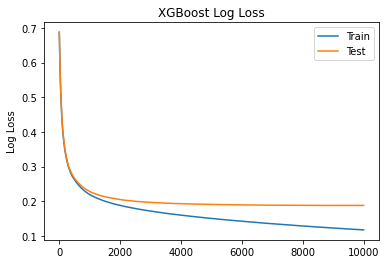

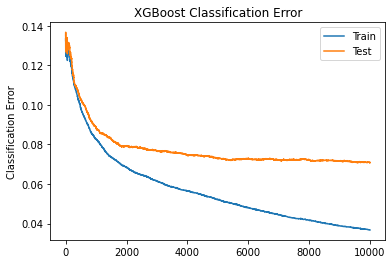

In [371]:
from matplotlib import pyplot

results = final_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()


## CatBoost

In [35]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    l2_leaf_reg=1.0
)

model.fit(
    x_train3, y_train3,
    cat_features=categorical_features_indices,
    eval_set=(x_test3, y_test3),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

CPU times: user 1min 11s, sys: 9.68 s, total: 1min 20s
Wall time: 25.1 s


In [37]:
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_test3, model.predict(x_test3))
))
print('')

print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_test3, earlystop_model.predict(x_test3))
))

Simple model tree count: 500
Simple model validation accuracy: 0.9309

Early-stopped model tree count: 300
Early-stopped model validation accuracy: 0.9274


# Import test data 

In [48]:
Xtest = pd.read_csv('Xtest.csv')

In [49]:
Xtest.head()

,Id,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv
0,0,Bayridge Grocery Inc.,BROOKLYN,NY,11209,BANK OF AMERICA NATL ASSOC,NC,445110,15-Dec-05,2006,...,6,0,1,Y,N,31-Dec-05,"$120,000.00",$0.00,"$100,000.00","$50,000.00"
1,1,SUBWAY,GILBERT,AZ,85297,INDEPENDENCE BANK,RI,722211,1-May-03,2003,...,0,78760,1,0,Y,30-Jun-03,"$130,000.00",$0.00,"$130,000.00","$110,500.00"
2,2,1-800 RADIATOR OF KATY,KATY,TX,77450,BANCO POPULAR NORTH AMERICA,NY,423120,17-Oct-06,2007,...,1,407,1,0,N,31-Dec-06,"$184,000.00",$0.00,"$184,000.00","$138,000.00"
3,3,"DAUGHTERY'S FOOD&FUEL CTR, INC",JEFFERSONVILLE,KY,40337,"COMMUNITY TRUST BANK, INC.",KY,447110,8-Nov-00,2001,...,0,1,1,N,N,30-Apr-01,"$80,000.00",$0.00,"$135,000.00","$101,250.00"
4,4,"TGGP ENTERPRISES, LLC",TWINSBURG,OH,44087,CAPITAL ONE NATL ASSOC,VA,722110,27-Oct-05,2006,...,9,0,1,N,N,31-Dec-05,"$50,000.00",$0.00,"$50,000.00","$25,000.00"


# Testing & Output

## XGBoost

In [40]:
model = xgb.XGBClassifier(learning_rate=0.01, n_estimators=2000, max_depth=4,
 min_child_weight=0.8, gamma=0.0, subsample=0.7, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, reg_alpha=1e-5)
model.fit(x2, y2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=0.8, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
def xgb_preprocessing(data):
    data = data.fillna(-999)
    data['BankRate'] = data.apply (lambda row: bank_rate(row), axis=1)
    data['SBARate'] = data.apply (lambda row: sba_rate(row), axis=1)
    data['DisbursementFY'] = data.apply(lambda row: date_to_year(row), axis=1)
    data = data.drop(columns=['Id','Name','Zip','State','BankState','ApprovalDate','DisbursementDate','DisbursementGross','BalanceGross','GrAppv','SBA_Appv'])
    object_columns = data.select_dtypes(['object']).columns
    data[object_columns] = data[object_columns].astype('category')
    data[object_columns] = data[object_columns].apply(lambda x: x.cat.codes)
    return data

In [42]:
Xtest = xgb_preprocessing(Xtest)
Xtest.head()

,City,Bank,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,BankRate,SBARate,DisbursementFY
0,1122,284,445110,77,47,6,1.0,0,6,0,1,8,4,0.833333,0.416667,6
1,4218,1881,722211,74,120,10,2.0,0,0,78760,1,1,7,1.000000,0.850000,4
2,5659,264,423120,78,98,1,2.0,1,1,407,1,1,4,1.000000,0.750000,7
3,5521,924,447110,72,120,5,1.0,0,0,1,1,4,4,1.687500,1.265625,2
4,11766,582,722110,77,11,9,1.0,1,9,0,1,4,4,1.000000,0.500000,6


In [43]:
y_pred = model.predict(Xtest)

## CatBoost

In [44]:
params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'logging_level': 'Silent',
    'od_type': 'Iter',
    'od_wait': 50,
    'l2_leaf_reg': 1.0
}
train_pool = Pool(x3, y3, cat_features=categorical_features_indices)
model = CatBoostClassifier(**params)

In [45]:
model.fit(train_pool)

In [46]:
def cat_preprocessing(data):
    data = data.fillna(-999)
    data['BankRate'] = data.apply (lambda row: bank_rate(row), axis=1)
    data['SBARate'] = data.apply (lambda row: sba_rate(row), axis=1)
    data['DisbursementFY'] = data.apply(lambda row: date_to_year(row), axis=1)
    data = data.drop(columns=['Id','Name','Zip','State','BankState','ApprovalDate','DisbursementDate','DisbursementGross','BalanceGross','GrAppv','SBA_Appv'])
    data['NewExist'] = data['NewExist'].astype(np.int)
    return data

In [50]:
Xtest = cat_preprocessing(Xtest)
Xtest.head()

,City,Bank,NAICS,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,BankRate,SBARate,DisbursementFY
0,BROOKLYN,BANK OF AMERICA NATL ASSOC,445110,2006,47,6,1,0,6,0,1,Y,N,0.833333,0.416667,05
1,GILBERT,INDEPENDENCE BANK,722211,2003,120,10,2,0,0,78760,1,0,Y,1.000000,0.850000,03
2,KATY,BANCO POPULAR NORTH AMERICA,423120,2007,98,1,2,1,1,407,1,0,N,1.000000,0.750000,06
3,JEFFERSONVILLE,"COMMUNITY TRUST BANK, INC.",447110,2001,120,5,1,0,0,1,1,N,N,1.687500,1.265625,01
4,TWINSBURG,CAPITAL ONE NATL ASSOC,722110,2006,11,9,1,1,9,0,1,N,N,1.000000,0.500000,05


In [51]:
y_pred = model.predict(Xtest)

In [52]:
len(y_pred)

100000

In [53]:
out = pd.DataFrame()
out['Id'] = range(len(y_pred))
out['ChargeOff'] = y_pred

In [54]:
out.to_csv('out.csv', index=False)